In [2]:
import sys
import pandas as pd
import os
import re
from tqdm import tqdm
import glob
import numpy as np
from typing import Tuple
import pickle
import seaborn as sns 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

def estimate_metrics(prediction, reference, structure):
    
    def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
        """Preprocesses input data by combining source and target into a frozenset."""
        df['combined'] = df.loc[:, ['source', 'target']].apply(frozenset, axis=1)
        return df
    
    def merge_datasets(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
        """Merges two datasets and removes duplicates."""
        merged = pd.merge(df1, df2, how='outer', on=["combined"], indicator=True)
        merged.drop_duplicates(subset='combined', keep="last", inplace=True)
        merged['source'] = merged['source_x'].fillna(merged.pop('source_y'))
        merged['target'] = merged['target_x'].fillna(merged.pop('target_y'))
        merged.drop(["combined", 'source_x', 'target_x'], axis=1, inplace=True)
        return merged

    # Preprocess prediction and reference data
    pred = preprocess_data(prediction.loc[:, ['source', 'target']])
    ref = preprocess_data(reference.loc[:, ['source', 'target']])

    # Merge datasets and calculate membership for confusion matrix
    merged_sets = merge_datasets(pred, ref)
    membership = merged_sets['_merge'].value_counts().to_dict()

    TP = membership['both']
    FP = membership['left_only']
    FN = membership['right_only']

    # Preprocess reference and structure data
    gold_net = preprocess_data(reference.loc[:, ['source', 'target']])
    structure = preprocess_data(structure.loc[:, ['source', 'target']])

    # Merge datasets and calculate TN
    merged_sets = merge_datasets(gold_net, structure)
    GS_negatives = merged_sets[merged_sets._merge == 'right_only']
    pred = preprocess_data(prediction.loc[:, ['source', 'target']])
    GS_negatives = preprocess_data(GS_negatives.loc[:, ['source', 'target']])
    merged_sets = merge_datasets(pred, GS_negatives)
    TN = merged_sets['_merge'].value_counts()['right_only']

    # Calculate metrics
    Precision = TP / (TP + FP) if TP + FP != 0 else 0
    Recall = TP / (TP + FN) if TP + FN != 0 else 0
    F1score = 2 / (1 / Precision + 1 / Recall) if Precision + Recall != 0 else 0
    MCC_numerator = TP * TN - FP * FN
    MCC_denominator = ((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) ** 0.5
    MCC = MCC_numerator / MCC_denominator if MCC_denominator != 0 and np.isfinite(MCC_numerator / MCC_denominator).all() else 0

    return Precision, Recall, F1score, MCC


In [94]:
test_case_folder = "/home/bbb1417/DRACOON_benchmarking/treelike/simulations"


expr_files = {}
cond_files = {}
out_files = {}
str_files = {}
ref_files = {}


benchmarks=['proportion_casecontrol',
                    'proportion_perturbed_genes',
                    'perturbation_noise',
                    'signal_noise',
                    'gene_number',
                   'ingroup_heterogeneity']

#benchmarks=['proportion_perturbed_genes']


for mode in os.listdir(test_case_folder):
    mode_path = os.path.join(test_case_folder, mode)
    for benchmark in benchmarks:
        print(benchmark)
        file_path = os.path.join(mode_path, benchmark)
        for casefile in os.listdir(file_path):
            # Only process .csv files
            if casefile.endswith('.csv'):
                complete_path = os.path.join(file_path, casefile)
                prefix = casefile.rsplit('_', 1)[0] # split from the right and append the underscore
                #print(prefix)

                if 'biomdata' in casefile:
                    expr_files[prefix] = complete_path
                    out_files[prefix] = complete_path.replace('simulations', 'results').replace('biomdata.csv', '')
                elif 'conddata' in casefile:
                    cond_files[prefix] = complete_path
                elif 'structure' in casefile:
                    str_files[prefix] = complete_path
                elif 'refnet' in casefile:
                    ref_files[prefix] = complete_path

proportion_casecontrol
proportion_perturbed_genes
perturbation_noise
signal_noise
gene_number
ingroup_heterogeneity


In [54]:
result_files = {}


for key in out_files.keys():
    path = out_files[key].split('/')[:-1]
    path = '/'.join(path)
    filename_pattern = out_files[key].split('/')[-1]
    
    # Use glob to get all files that match the pattern
    files = glob.glob(path + '/'+ filename_pattern+'*')
    result_files[key] = []
    # Print the list of filepaths
    for file in files:
        result_files[key].append(file)
 

# Analyzing results

In [91]:
# metrics = ['pearson', 'spearman', 'entropy']
# runs = range(5)


# dracombined = {}

# for metric in metrics:
#     dracombined[metric] = {}
#     for run in runs:
#         dracombined[metric][run] = []

In [92]:

# for key in tqdm(result_files.keys()):
#     #print(key)
    
#     for pred_file in result_files[key]:
#         nettype = pred_file.split('___')[-1]
        
#         if 'dracoon' in pred_file:
#         #print(pred_file)
#             nettype = nettype.replace('.csv','').replace('algr', '')
#             run = int(nettype.split('_')[-1])
#             method = '-'.join(nettype.split('_')[:-1])
#             dracoasoc = nettype.split('_')[1]
            
#             dracombined[dracoasoc][run] = pred_file

#     for run in range(5):
#         pearsonnet = pd.read_csv(dracombined['pearson'][run], index_col=0)
#         spearmannet = pd.read_csv(dracombined['spearman'][run], index_col=0)
#         entropynet =  pd.read_csv(dracombined['entropy'][run], index_col=0)

#         pearsonnet[['shift','padj_shift']] = entropynet[['shift','padj_shift']]
#         pearsonnet.to_csv(dracombined['pearson'][run].replace('pearson', 'pearsonentropy'))

#         spearmannet[['shift','padj_shift']] = entropynet[['shift','padj_shift']]
#         spearmannet.to_csv(dracombined['spearman'][run].replace('spearman', 'spearmanentropy'))



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [01:32<00:00,  2.22it/s]


In [4]:
pvalue_cutoff = 0.1

In [1]:

# results = []
# for key in tqdm(result_files.keys()):
#     #print(key)
    
#     for pred_file in result_files[key]:
#         nettype = pred_file.split('___')[-1]
#         #print(pred_file)

#         if nettype.count('_') == 1:
#             nettype = nettype.replace('.csv','').replace('algr', '')
#             method, run = nettype.split('_')
#         else:
#             nettype = nettype.replace('.csv','').replace('algr', '')
#             run = nettype.split('_')[-1]
#             method = '-'.join(nettype.split('_')[:-1])
        
#         predicted = pd.read_csv(pred_file)
#         refnet = pd.read_csv(ref_files[key], index_col=0)
#         strucnet = pd.read_csv(str_files[key], index_col=0)
        
#         if 'dracoon' in method:
#             draco1 = predicted[predicted['padj_absdiff'] < pvalue_cutoff]
#             prec, rec, f1, mcc = estimate_metrics(prediction=draco1, reference=refnet, structure=strucnet)
#             results.append([key, method+'-absdiff', run,  prec, rec, f1, mcc])
            
#             draco2 = predicted[predicted['padj_shift'] < pvalue_cutoff]
#             prec, rec, f1, mcc = estimate_metrics(prediction=draco2, reference=refnet, structure=strucnet)
#             results.append([key, method+'-shift', run,  prec, rec, f1, mcc])

#             draco3 = predicted[(predicted['padj_absdiff'] < pvalue_cutoff) | (predicted['padj_shift'])]
#             prec, rec, f1, mcc = estimate_metrics(prediction=draco3, reference=refnet, structure=strucnet)
#             results.append([key, method+'-absdiffshift', run,  prec, rec, f1, mcc])

#         else: 
#             predicted = predicted[predicted['adj_pval'] < pvalue_cutoff]
#             prec, rec, f1, mcc = estimate_metrics(prediction=predicted, reference=refnet, structure=strucnet)
#             results.append([key, method, run,  prec, rec, f1, mcc])
#         #print(method, run)


In [ ]:
# final_results = pd.DataFrame(results, columns = ['simulation', 'method', 'run','prec', 'rec', 'f1', 'mcc'])
# final_results.to_csv('/home/bbb1417/DRACOON_benchmarking/treelike/results/final_results.csv')

# Plotting

In [3]:
final_results = pd.read_csv('/home/bbb1417/DRACOON_benchmarking/treelike/results/final_results.csv', index_col=0)
final_results[['benchmark', 'ratio']] = final_results["simulation"].str.extract(r'(^.*?)_(\d+\.\d+)')


# Assuming that your DataFrame is named df
final_results['substring'] = final_results['simulation'].str.split('perts_').str[1].str.slice(0, -1)

# Split the substring into 4 new columns
final_results[['shuts', 'invs', 'shifts', 'locs']] = final_results['substring'].str.split('_', expand=True)

final_results


simulation  \
0              propCC_0.1_perts_40_0_0_0_   
1              propCC_0.1_perts_40_0_0_0_   
2              propCC_0.1_perts_40_0_0_0_   
3              propCC_0.1_perts_40_0_0_0_   
4              propCC_0.1_perts_40_0_0_0_   
...                                   ...   
23570  propingroup_0.9_perts_15_15_15_15_   
23571  propingroup_0.9_perts_15_15_15_15_   
23572  propingroup_0.9_perts_15_15_15_15_   
23573  propingroup_0.9_perts_15_15_15_15_   
23574  propingroup_0.9_perts_15_15_15_15_   

                                     method  run      prec       rec  \
0                                     dicer    0  1.000000  0.303571   
1                                  diffcoex    0  0.000000  0.000000   
2                               ebcoexpress    0  0.000000  0.000000   
3                                   entropy    0  1.000000  0.732143   
4                                      ftgi    0  1.000000  0.982143   
...                                     ...  ...       ...       ...   
23570          dracoon-pearsonentropy-shift    4  1.000000  0.975309   
23571   dracoon-pearsonentropy-absdiffshift    4  0.790698  0.839506   
23572       dracoon-spearmanentropy-absdiff    4  1.000000  0.814815   
23573         dracoon-spearmanentropy-shift    4  1.000000  0.975309   
23574  dracoon-spearmanentropy-absdiffshift    4  0.790698  0.839506   

             f1       mcc    benchmark ratio    substring shuts invs shifts  \
0      0.465753  0.398986       propCC   0.1     40_0_0_0    40    0      0   
1      0.000000  0.000000       propCC   0.1     40_0_0_0    40    0      0   
2      0.000000  0.000000       propCC   0.1     40_0_0_0    40    0      0   
3      0.845361  0.736747       propCC   0.1     40_0_0_0    40    0      0   
4      0.990991  0.979705       propCC   0.1     40_0_0_0    40    0      0   
...         ...       ...          ...   ...          ...   ...  ...    ...   
23570  0.987500  0.936898  propingroup   0.9  15_15_15_15    15   15     15   
23571  0.814371 -0.183280  propingroup   0.9  15_15_15_15    15   15     15   
23572  0.897959  0.666667  propingroup   0.9  15_15_15_15    15   15     15   
23573  0.987500  0.936898  propingroup   0.9  15_15_15_15    15   15     15   
23574  0.814371 -0.183280  propingroup   0.9  15_15_15_15    15   15     15   

      locs  
0        0  
1        0  
2        0  
3        0  
4        0  
...    ...  
23570   15  
23571   15  
23572   15  
23573   15  
23574   15  

[23575 rows x 14 columns]

# 1. Comparing perturbed and control group sizes

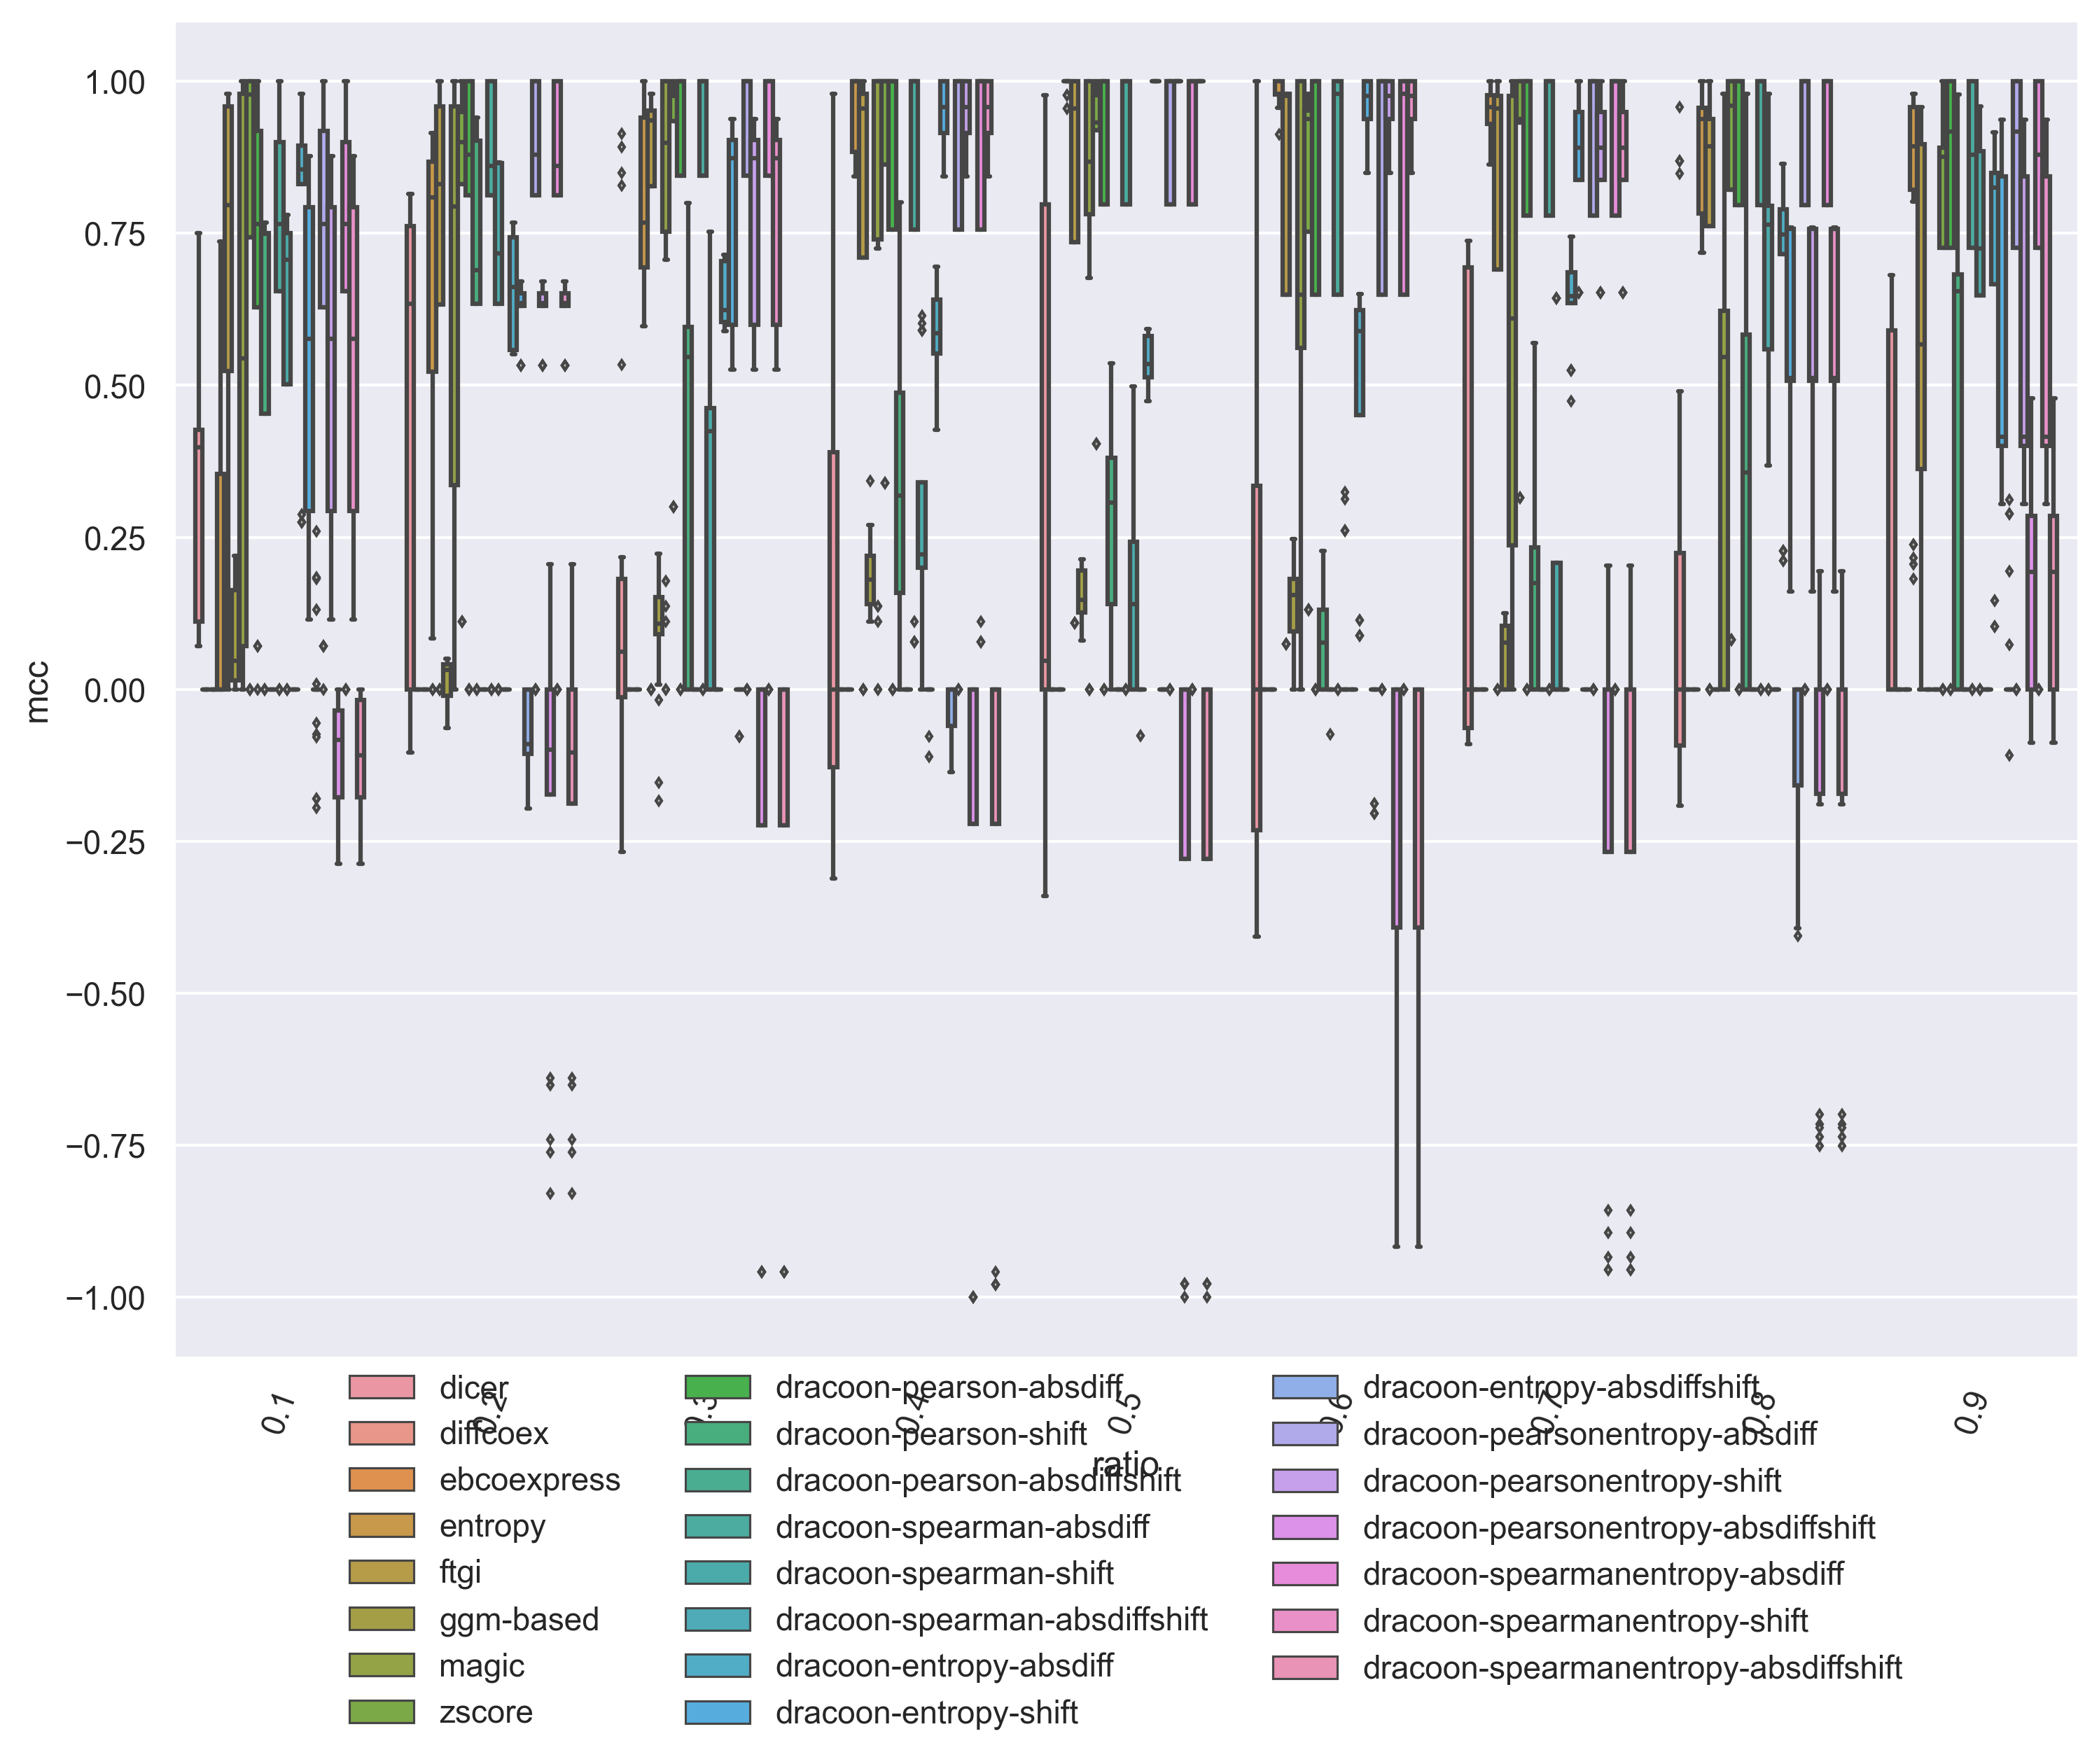

                                  method      mean       std         CV
0                                entropy  0.796935  0.299887   0.376301
1                                 zscore  0.787447  0.315593   0.400780
2          dracoon-spearmanentropy-shift  0.756280  0.243910   0.322513
3                  dracoon-entropy-shift  0.756280  0.243910   0.322513
4           dracoon-pearsonentropy-shift  0.756280  0.243910   0.322513
5         dracoon-pearsonentropy-absdiff  0.740638  0.381840   0.515555
6                dracoon-pearson-absdiff  0.740638  0.381840   0.515555
7        dracoon-spearmanentropy-absdiff  0.739970  0.379703   0.513133
8               dracoon-spearman-absdiff  0.739970  0.379703   0.513133
9                                   ftgi  0.699535  0.369608   0.528362
10               dracoon-entropy-absdiff  0.628448  0.189325   0.301257
11                                 magic  0.560368  0.422424   0.753833
12                dracoon-spearman-shift  0.379166  0.344321   0

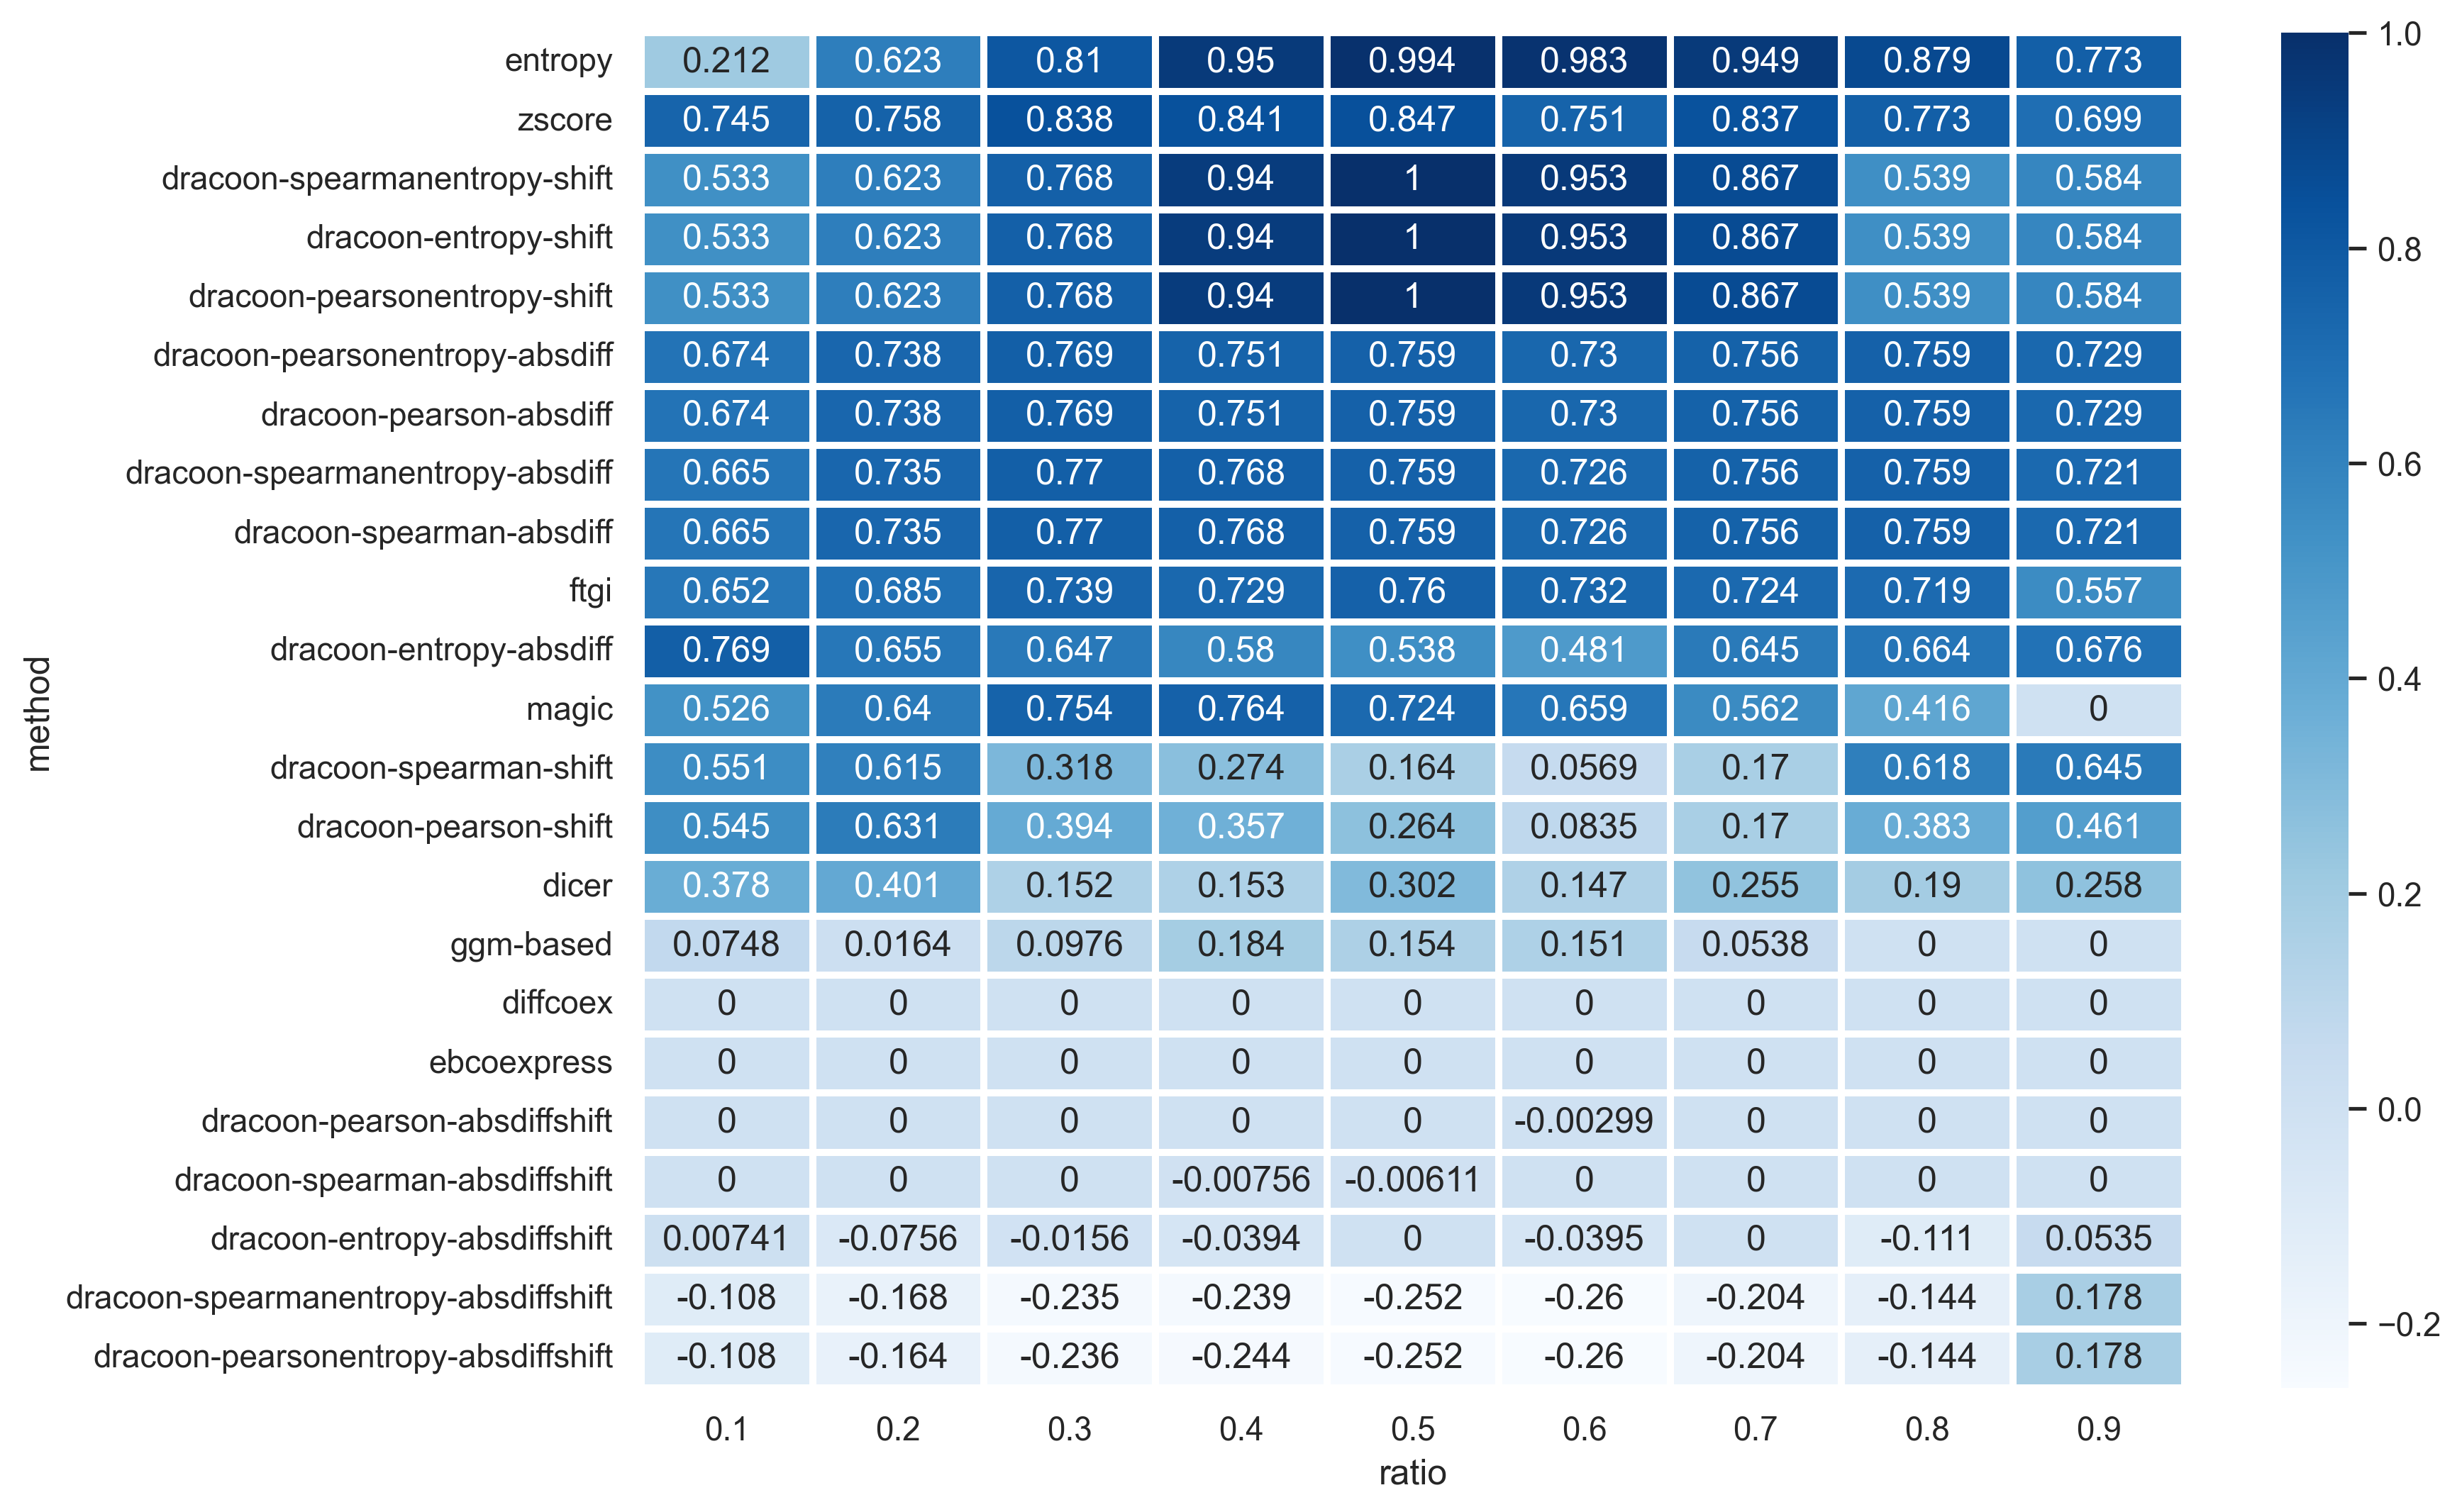

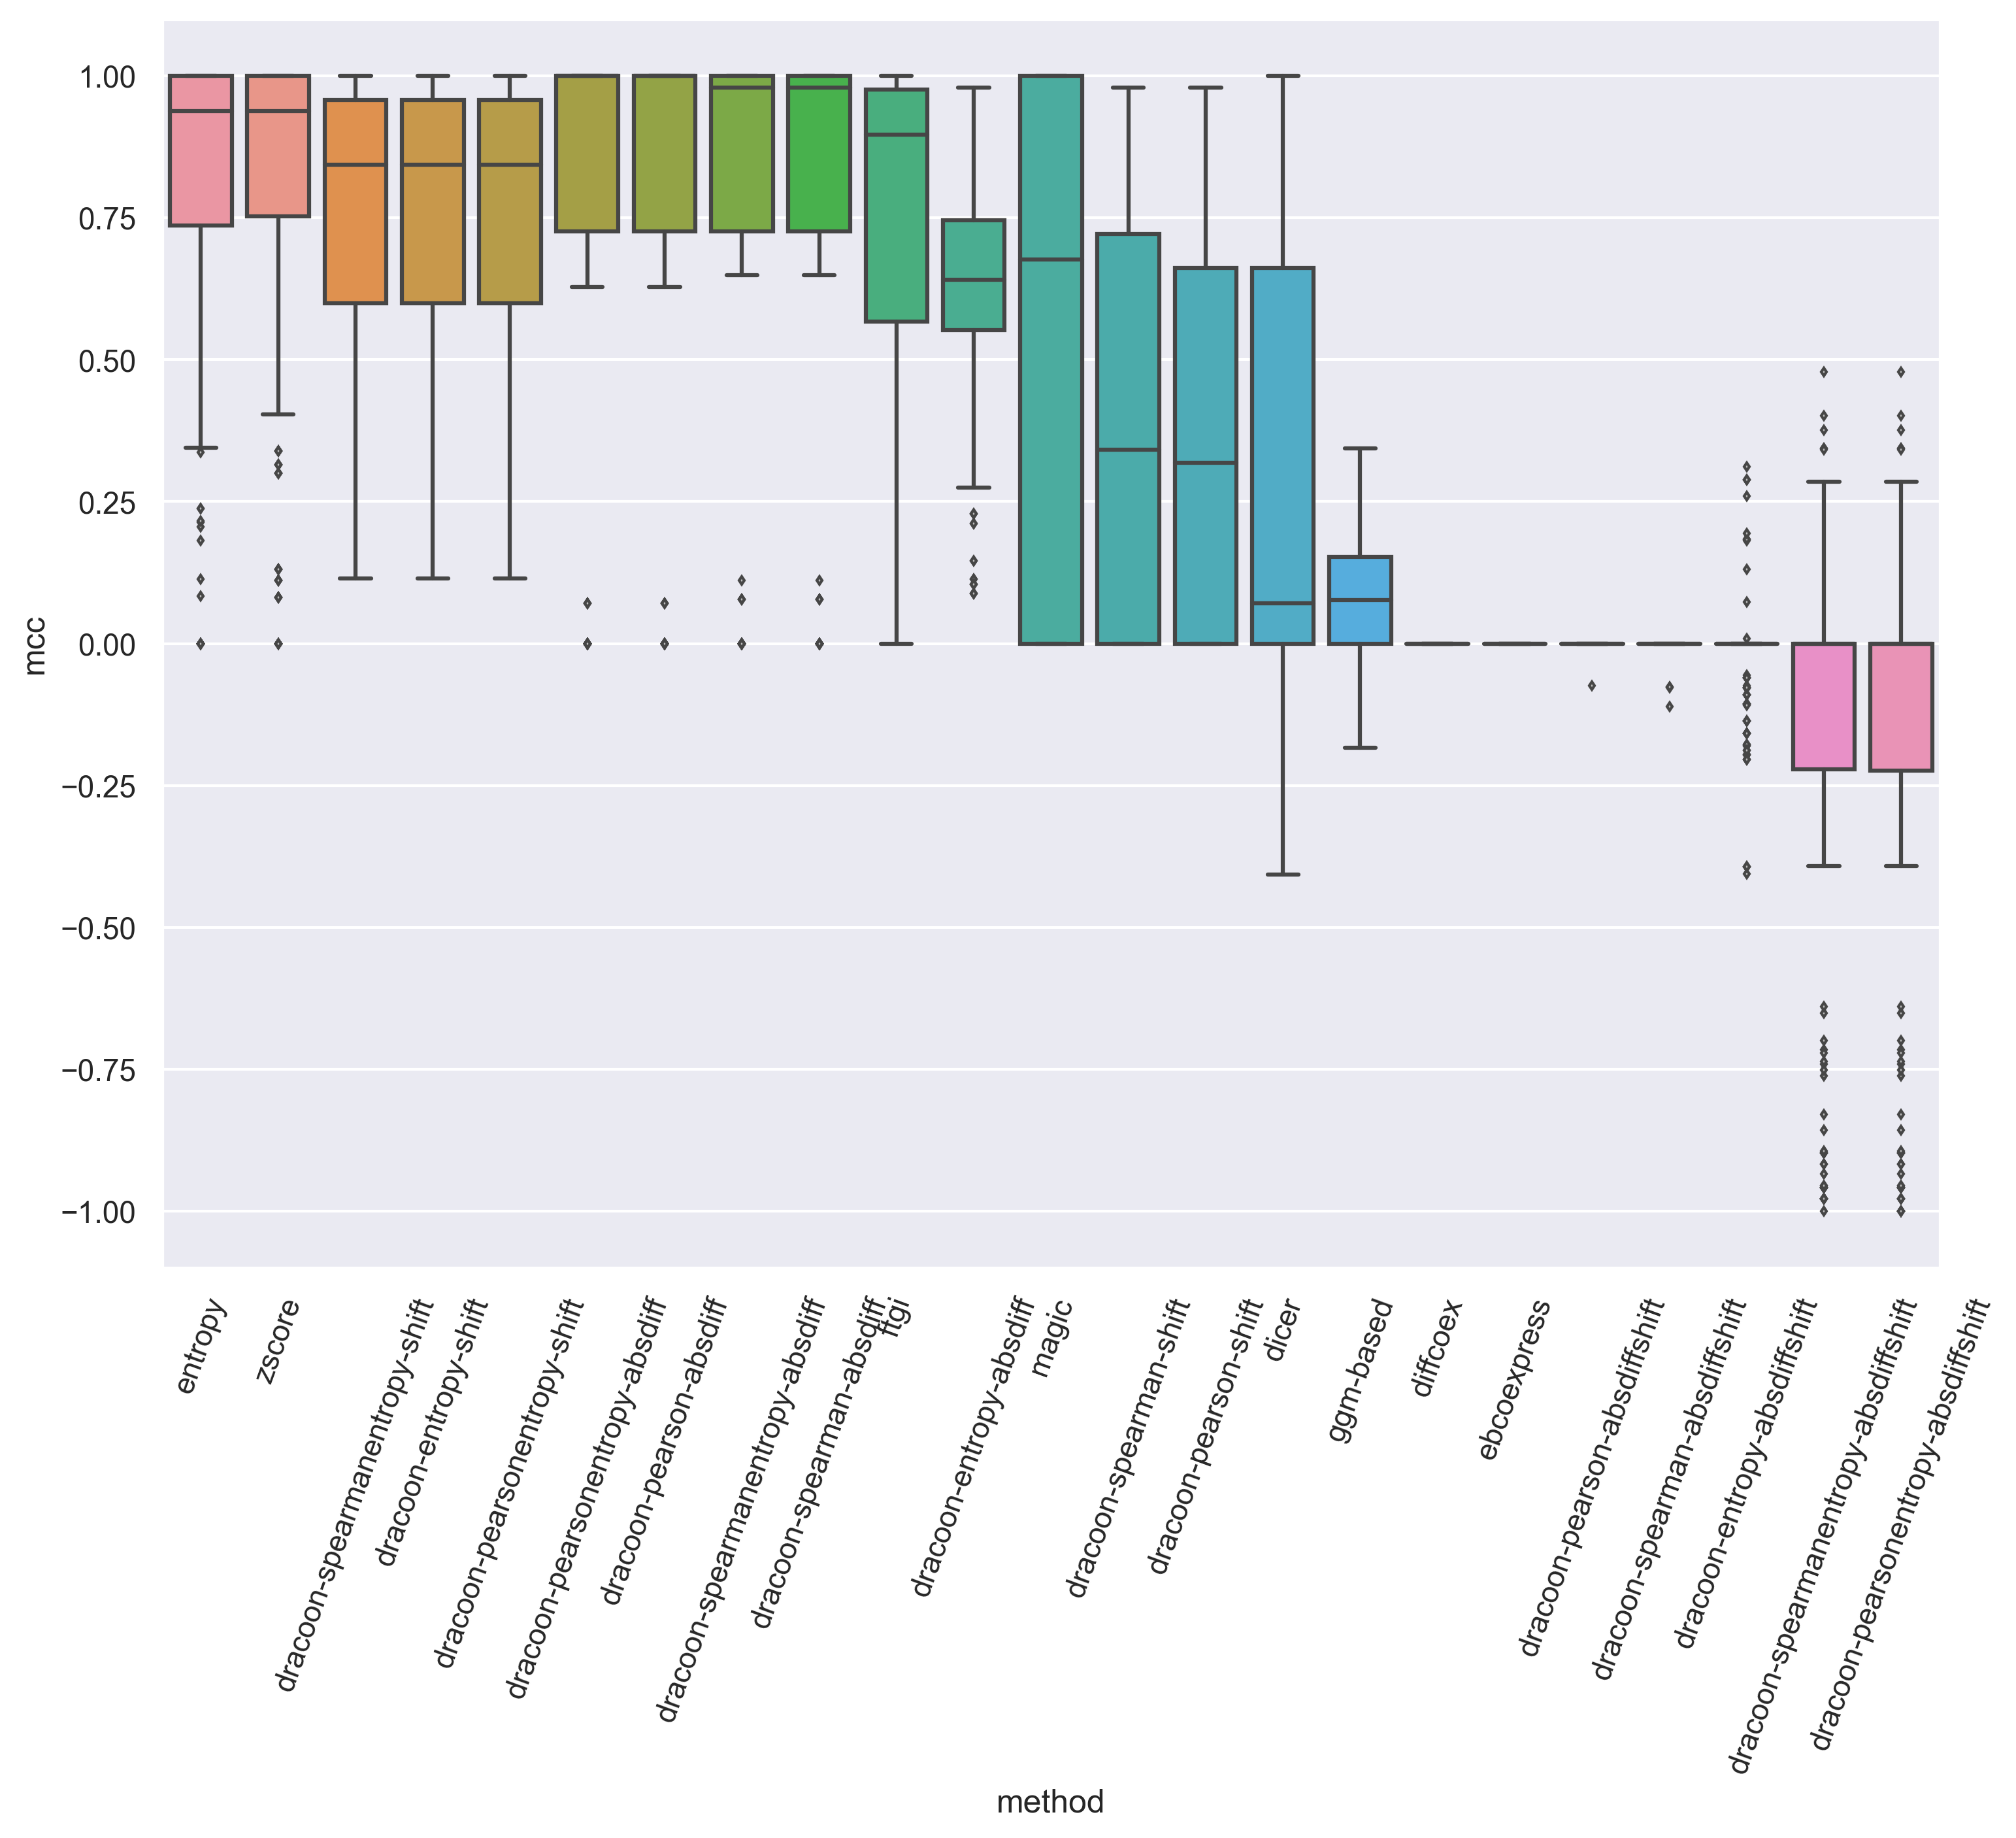

In [4]:
benchmark = 'propCC'
df = final_results[final_results['benchmark'] == benchmark]


sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['ratio'], y = df['mcc'],
            hue = df['method'], flierprops=flierprops)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, -.3),
    ncol=3,
    title=None, frameon=False,
)
plt.xticks(rotation=70)
plt.show()



result2 = df.groupby(['method', 'ratio'], as_index=False)['mcc'].agg(['mean','std'])
result2.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
result2['CV'] = result2['std']/abs(result2['mean'])
result2.reset_index()

result = result2.pivot_table(index='method', columns='ratio', values='mean')
result.index = pd.CategoricalIndex(result.index)
result.sort_index(level=0, inplace=True)


sumres = df.groupby('method', as_index=False)['mcc'].agg(['mean','std'])
sumres.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
sumres['CV'] = sumres['std']/abs(sumres['mean'])
sumres = sumres.sort_values('mean', ascending=False).reset_index()
print(sumres)

#result = result.set_index('method')
result = result.reindex(sumres['method'])
result = result.reset_index()

# plot the heatmap
sns.heatmap(result.set_index('method'), annot=True, cmap='Blues', fmt=".3g", linewidths=2, linecolor='white')
plt.show()

sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['method'], y = df['mcc'], flierprops=flierprops, order=sumres['method'])
plt.xticks(rotation=70)
plt.show()

# 2. Comparing proportion of perturbed genes

In [5]:
final_results['benchmark'].value_counts()

propCC          5175
propPertG       5175
propingroup     5175
perturbnoise    1725
signalnoise     1725
Name: benchmark, dtype: int64

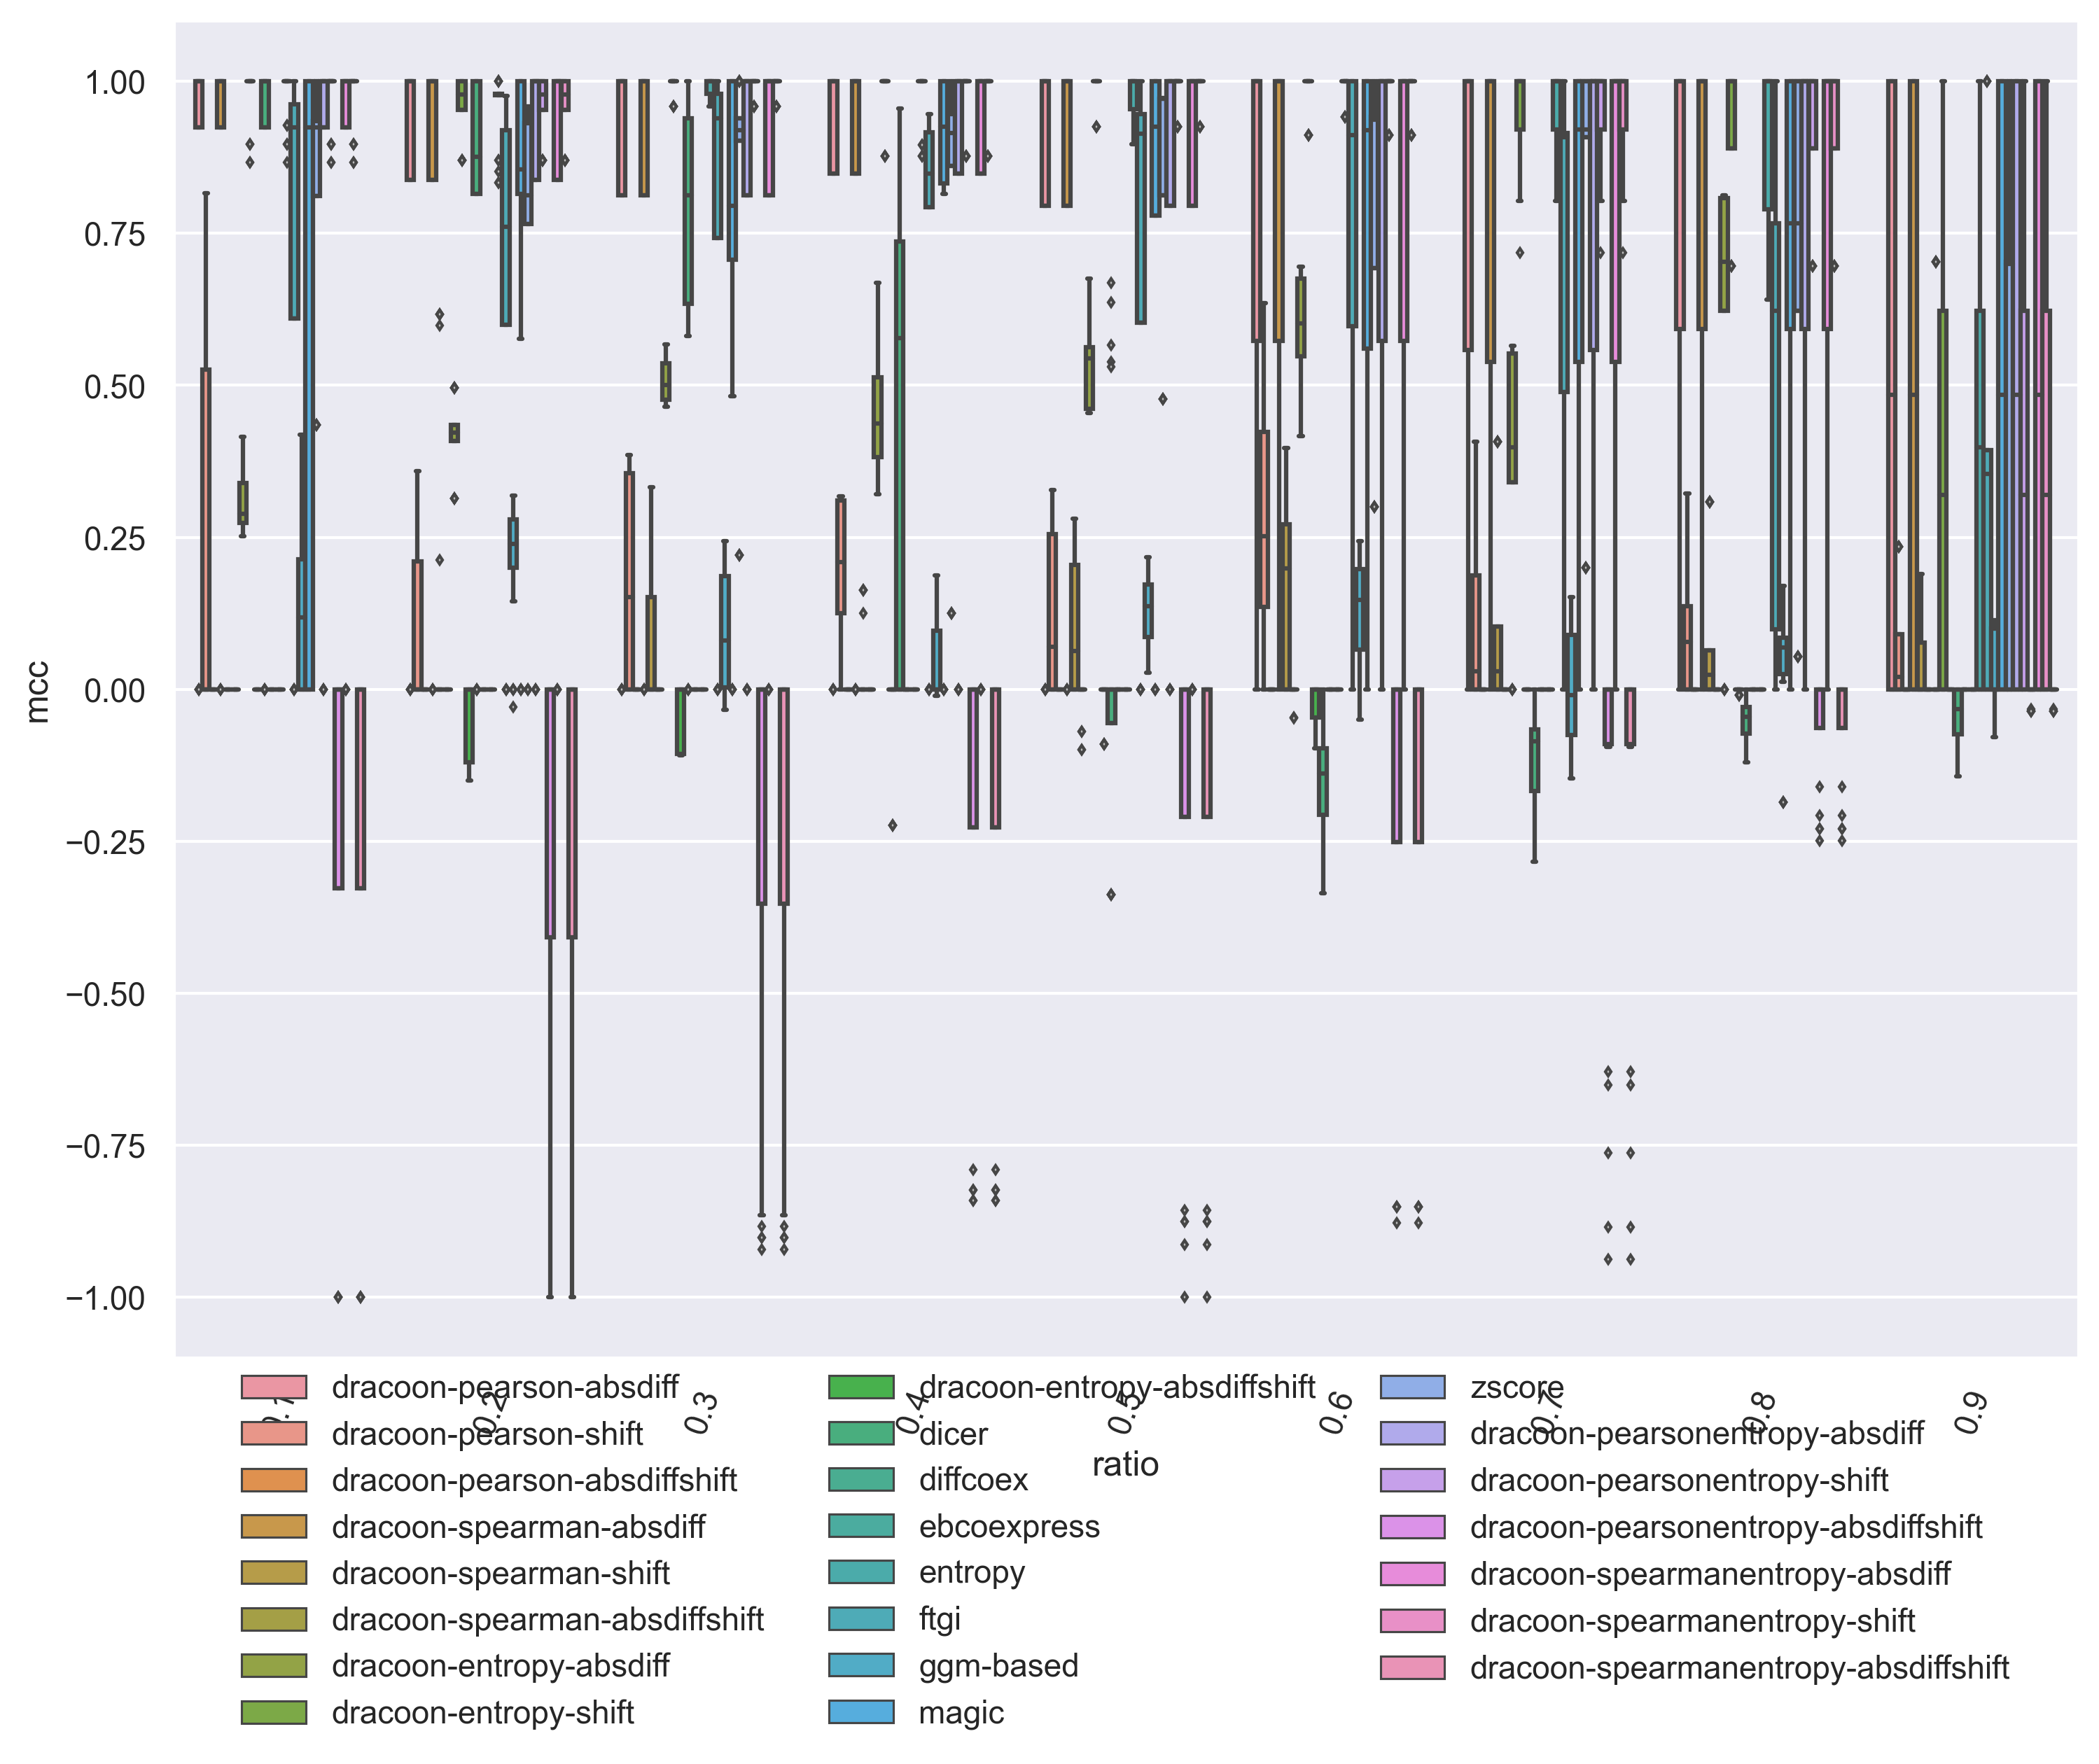

                                  method      mean       std        CV
0          dracoon-spearmanentropy-shift  0.902099  0.231222  0.256315
1                  dracoon-entropy-shift  0.902099  0.231222  0.256315
2           dracoon-pearsonentropy-shift  0.902099  0.231222  0.256315
3                                entropy  0.901924  0.227540  0.252283
4                                 zscore  0.741238  0.323799  0.436836
5         dracoon-pearsonentropy-absdiff  0.720514  0.407241  0.565209
6                dracoon-pearson-absdiff  0.720514  0.407241  0.565209
7        dracoon-spearmanentropy-absdiff  0.720261  0.407349  0.565558
8               dracoon-spearman-absdiff  0.720261  0.407349  0.565558
9                                  magic  0.676436  0.402987  0.595751
10                                  ftgi  0.631959  0.390852  0.618476
11               dracoon-entropy-absdiff  0.435641  0.216126  0.496111
12                                 dicer  0.255599  0.466088  1.823509
13    

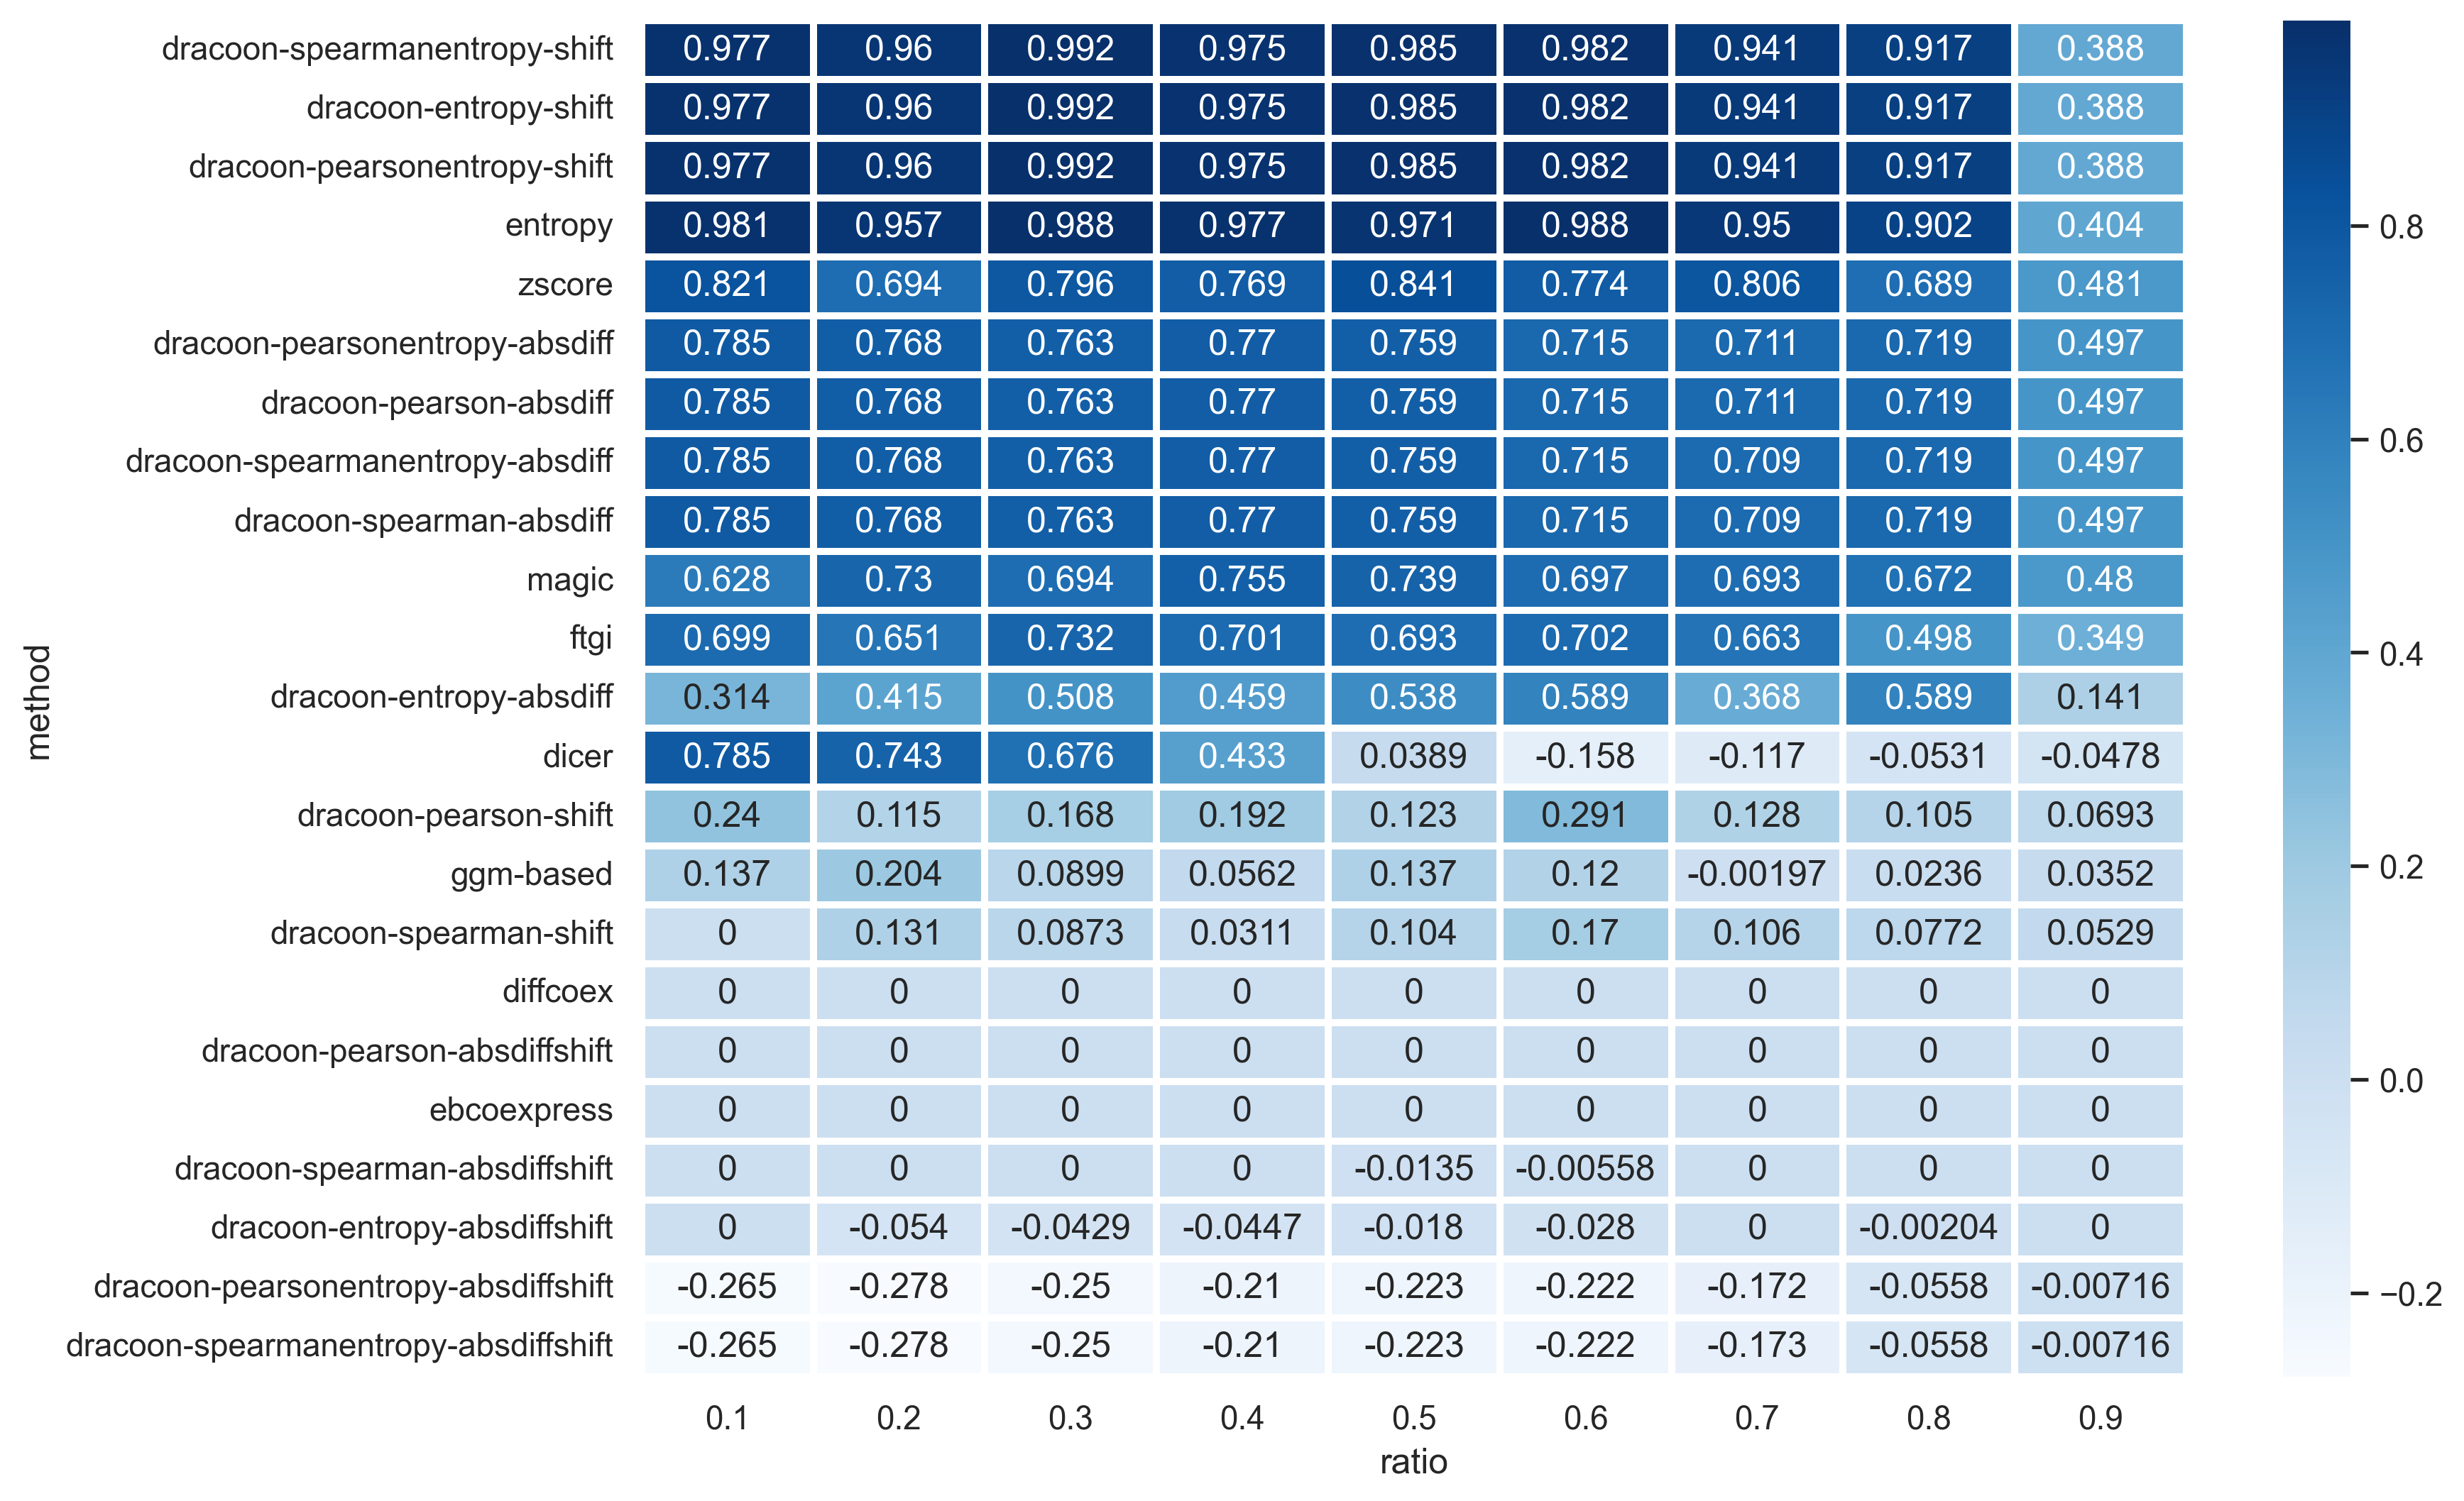

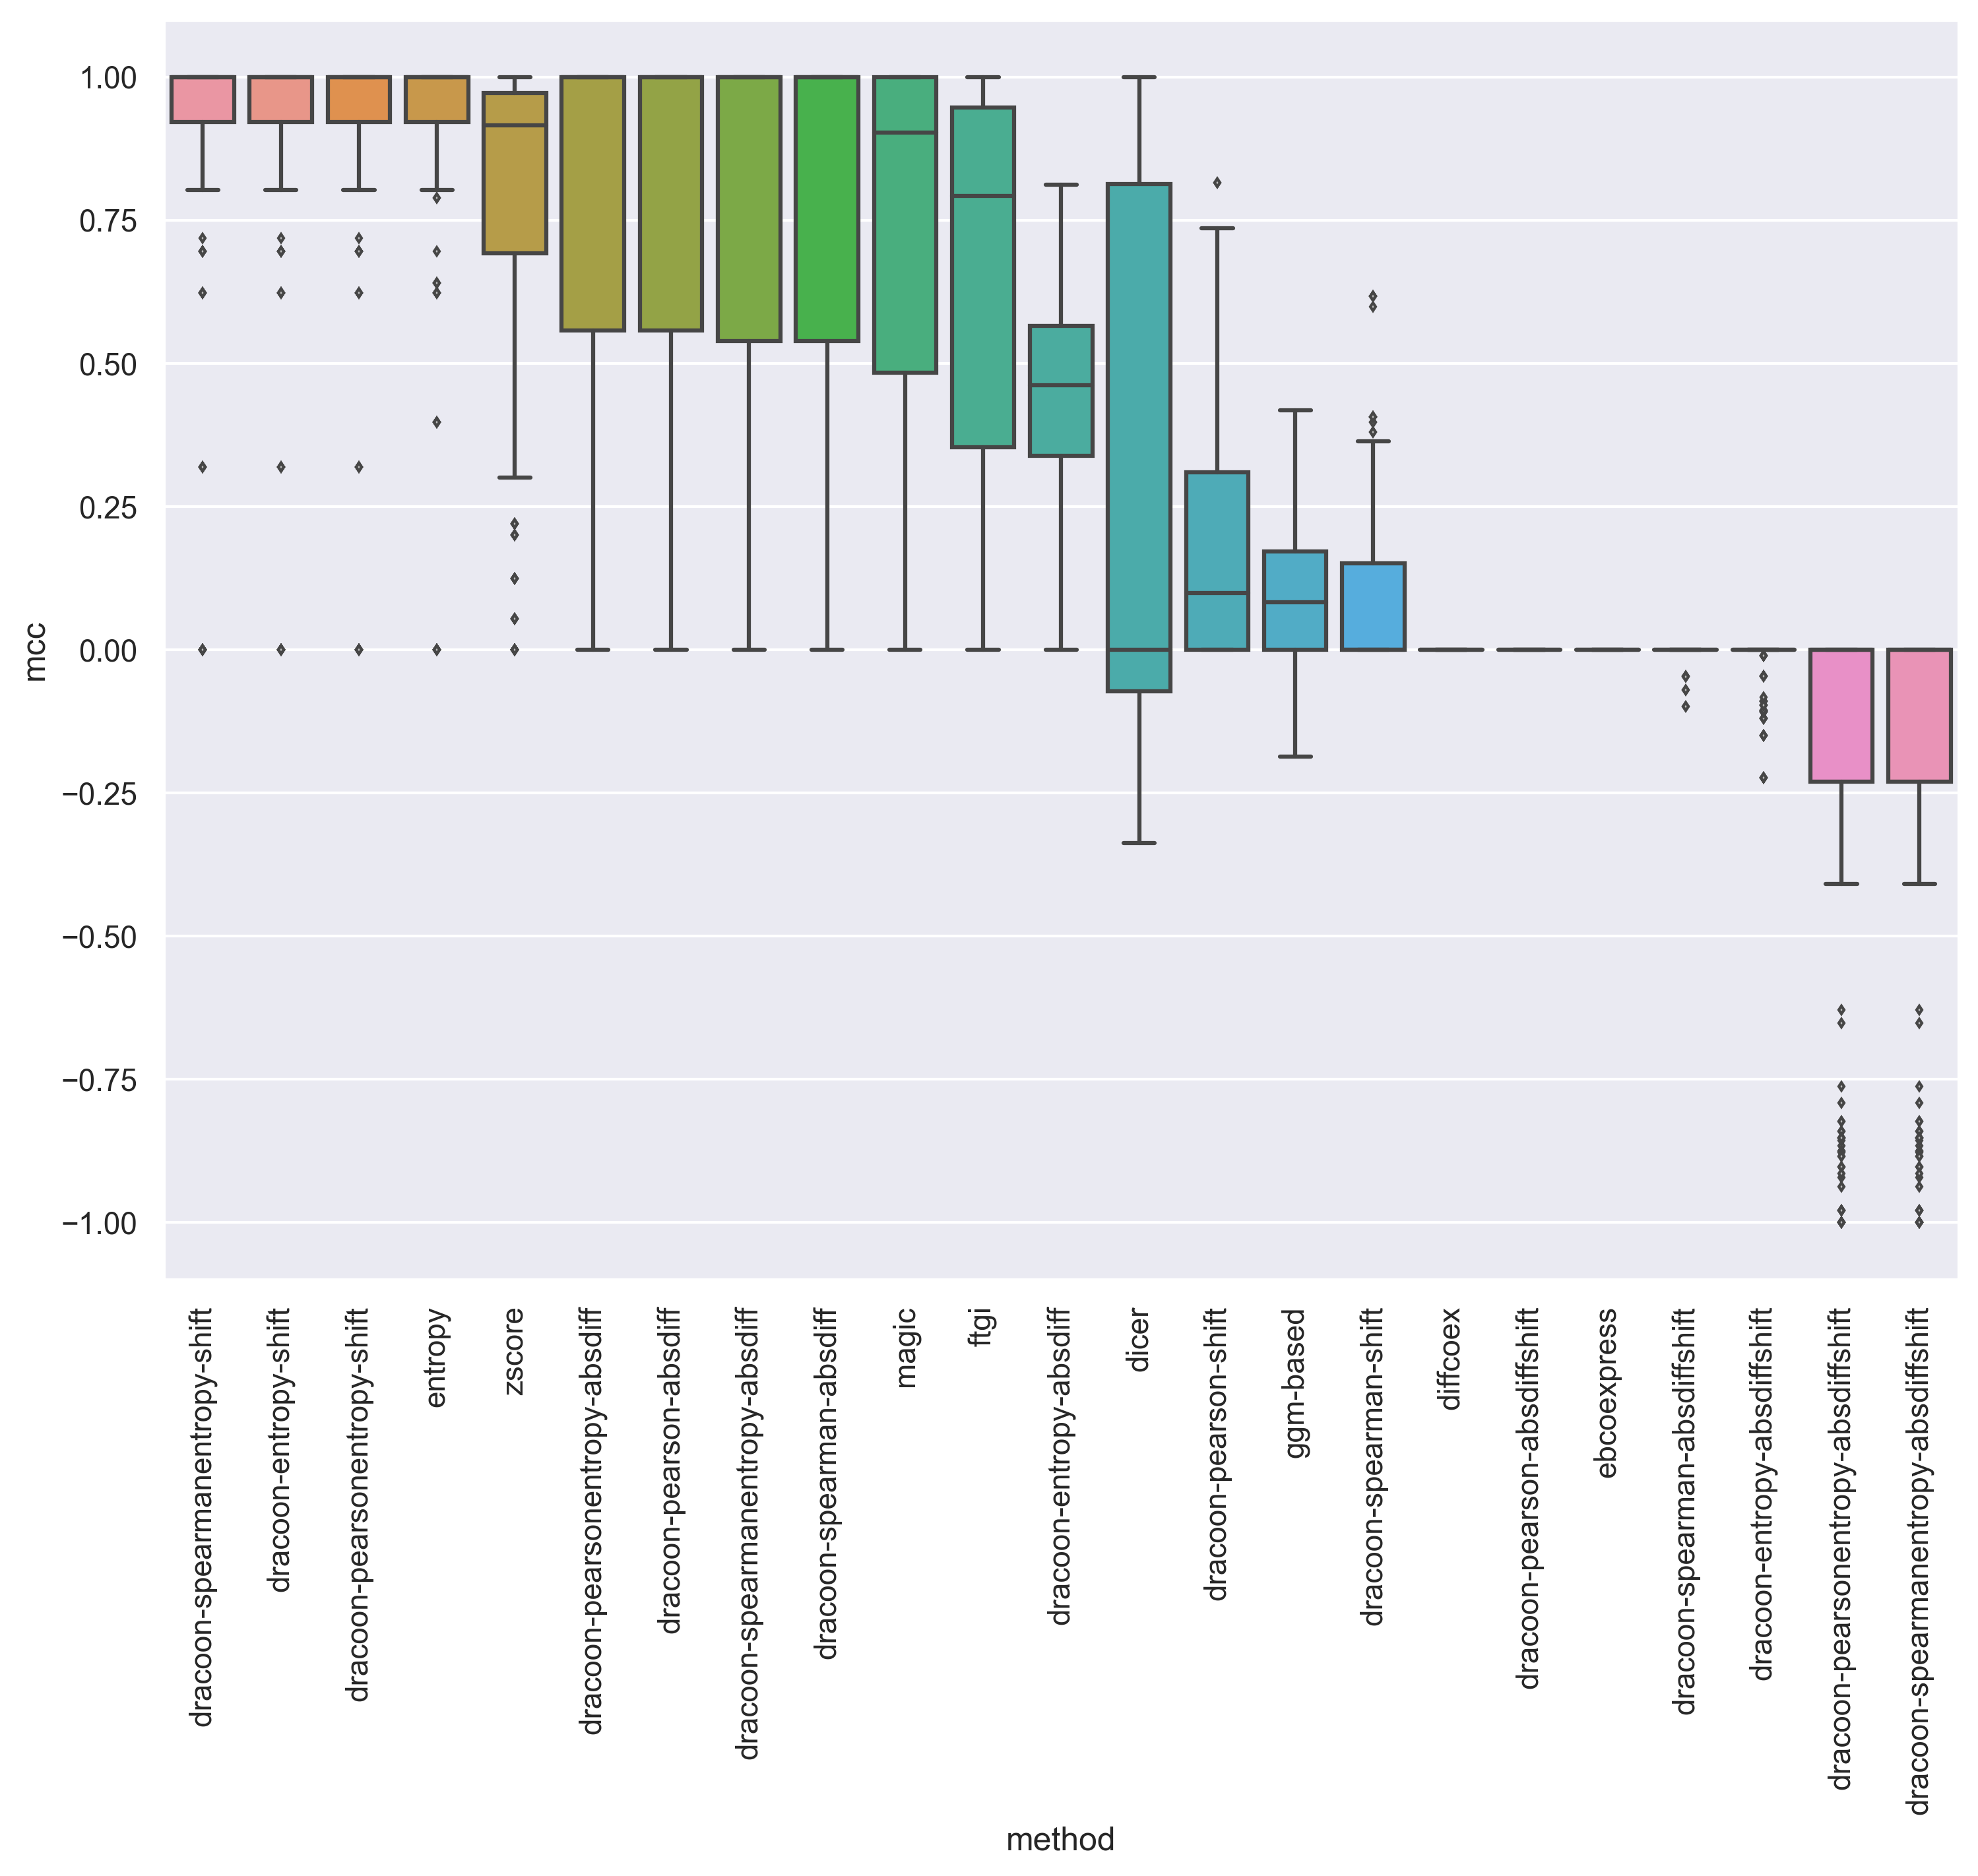

In [6]:
benchmark = 'propPertG'
df = final_results[final_results['benchmark'] == benchmark]


sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['ratio'], y = df['mcc'],
            hue = df['method'], flierprops=flierprops)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, -.3),
    ncol=3,
    title=None, frameon=False,
)
plt.xticks(rotation=70)
plt.show()



result2 = df.groupby(['method', 'ratio'], as_index=False)['mcc'].agg(['mean','std'])
result2.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
result2['CV'] = result2['std']/abs(result2['mean'])
result2.reset_index()

result = result2.pivot_table(index='method', columns='ratio', values='mean')
result.index = pd.CategoricalIndex(result.index)
result.sort_index(level=0, inplace=True)


sumres = df.groupby('method', as_index=False)['mcc'].agg(['mean','std'])
sumres.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
sumres['CV'] = sumres['std']/abs(sumres['mean'])
sumres = sumres.sort_values('mean', ascending=False).reset_index()
print(sumres)

#result = result.set_index('method')
result = result.reindex(sumres['method'])
result = result.reset_index()

# plot the heatmap
sns.heatmap(result.set_index('method'), annot=True, cmap='Blues', fmt=".3g", linewidths=2, linecolor='white')
plt.show()

sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['method'], y = df['mcc'], flierprops=flierprops, order=sumres['method'])
plt.xticks(rotation=90)
plt.show()

# 3. Perturbation noise

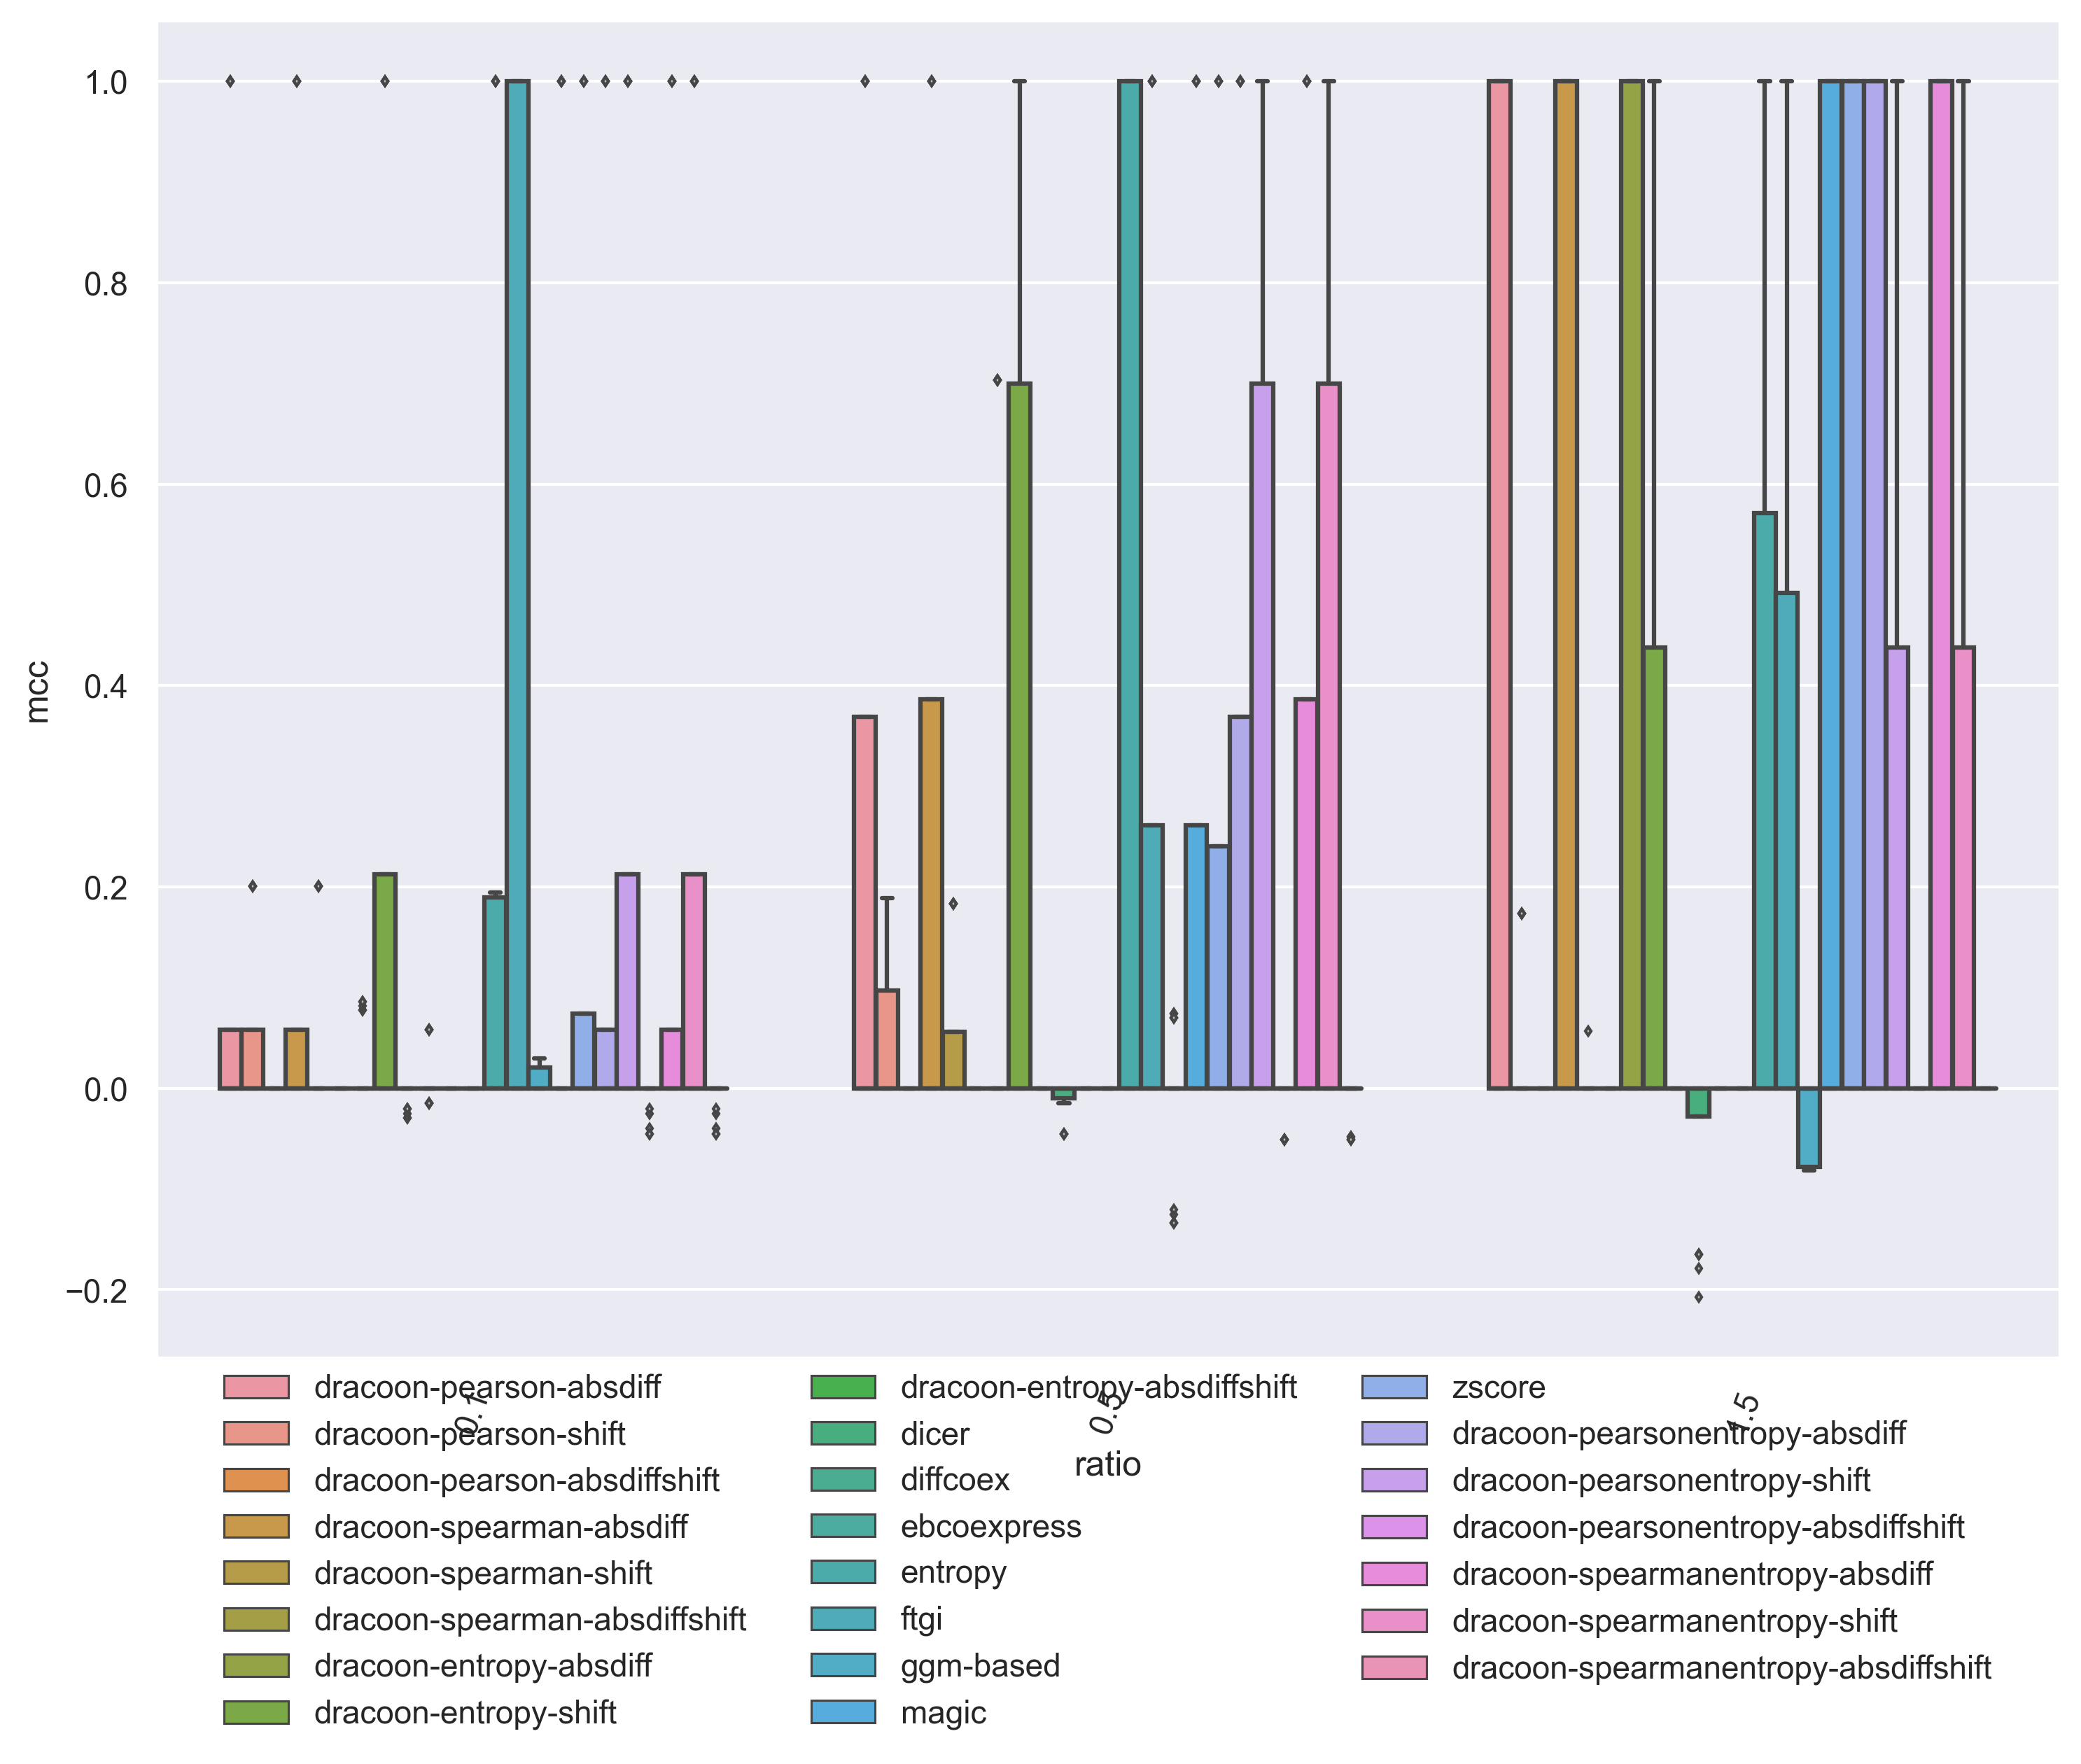

                                  method      mean       std        CV
0                                entropy  0.317226  0.438984  1.383821
1                                   ftgi  0.316887  0.435286  1.373632
2               dracoon-spearman-absdiff  0.295635  0.437594  1.480184
3        dracoon-spearmanentropy-absdiff  0.295635  0.437594  1.480184
4                dracoon-pearson-absdiff  0.295173  0.437506  1.482200
5         dracoon-pearsonentropy-absdiff  0.295173  0.437506  1.482200
6           dracoon-pearsonentropy-shift  0.289901  0.408136  1.407846
7                  dracoon-entropy-shift  0.289901  0.408136  1.407846
8          dracoon-spearmanentropy-shift  0.289901  0.408136  1.407846
9                                 zscore  0.287666  0.436673  1.517987
10                                 magic  0.283609  0.439452  1.549498
11               dracoon-entropy-absdiff  0.185690  0.366171  1.971947
12                 dracoon-pearson-shift  0.047715  0.075292  1.577974
13    

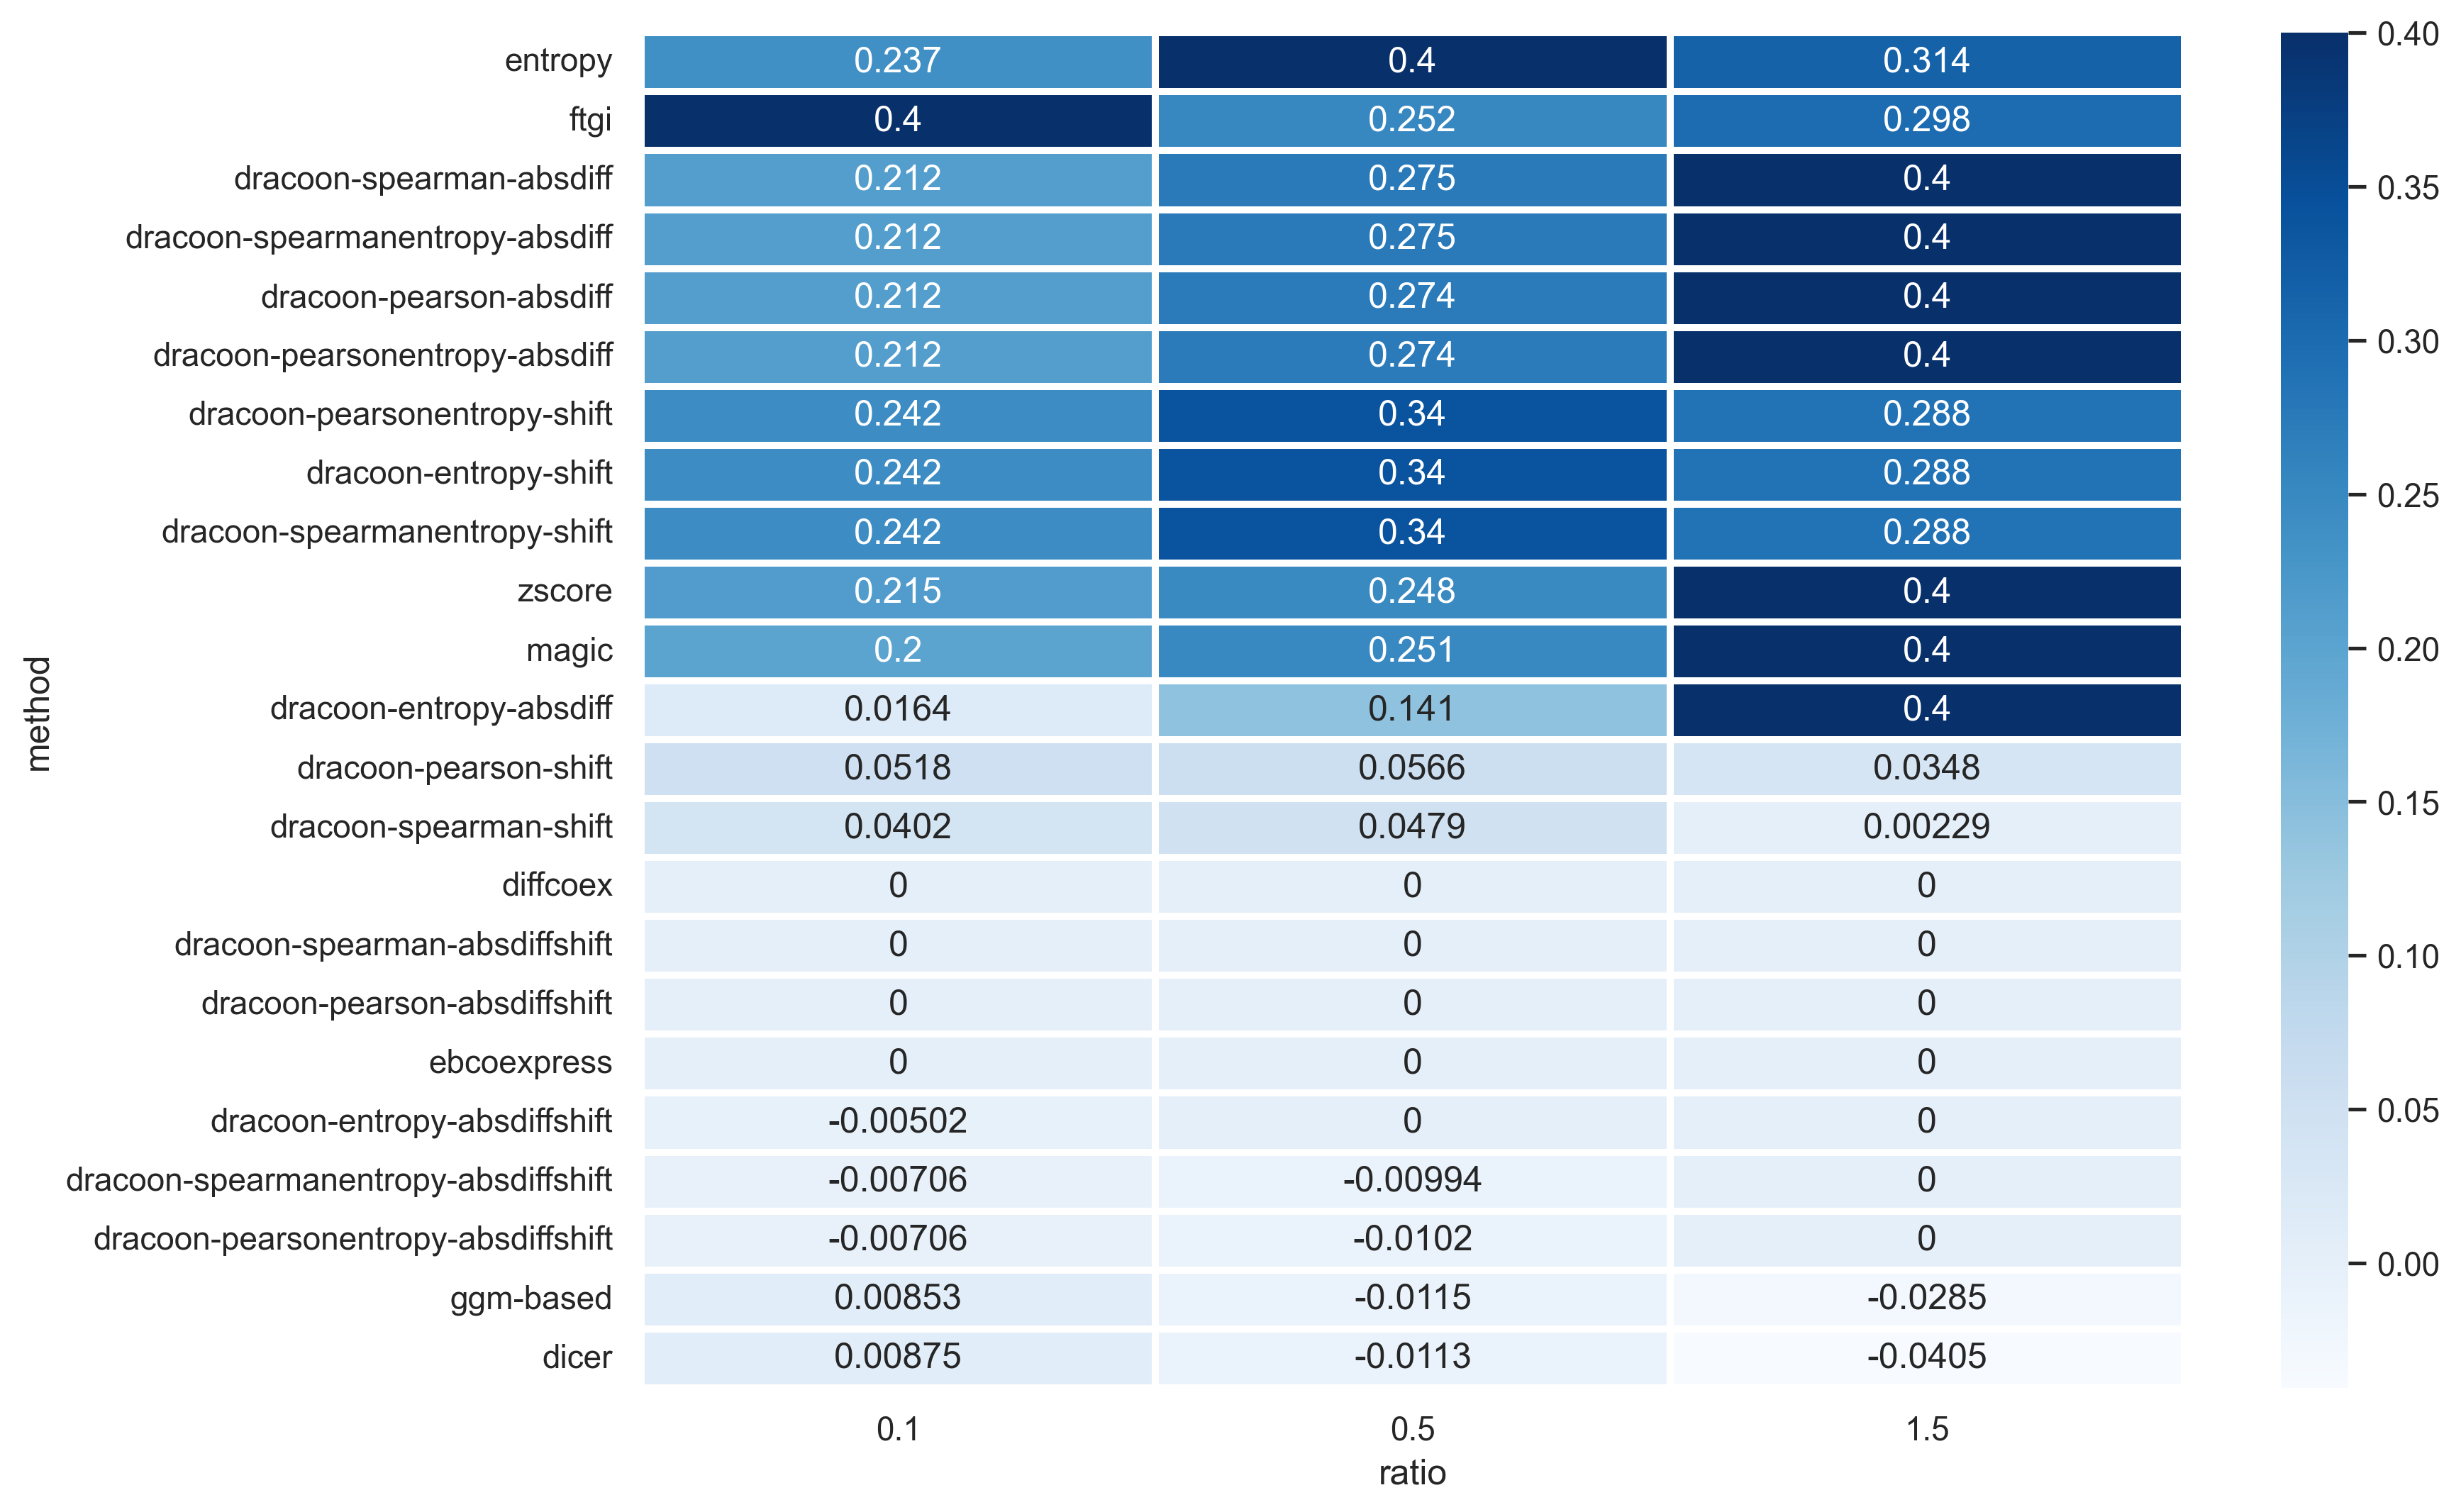

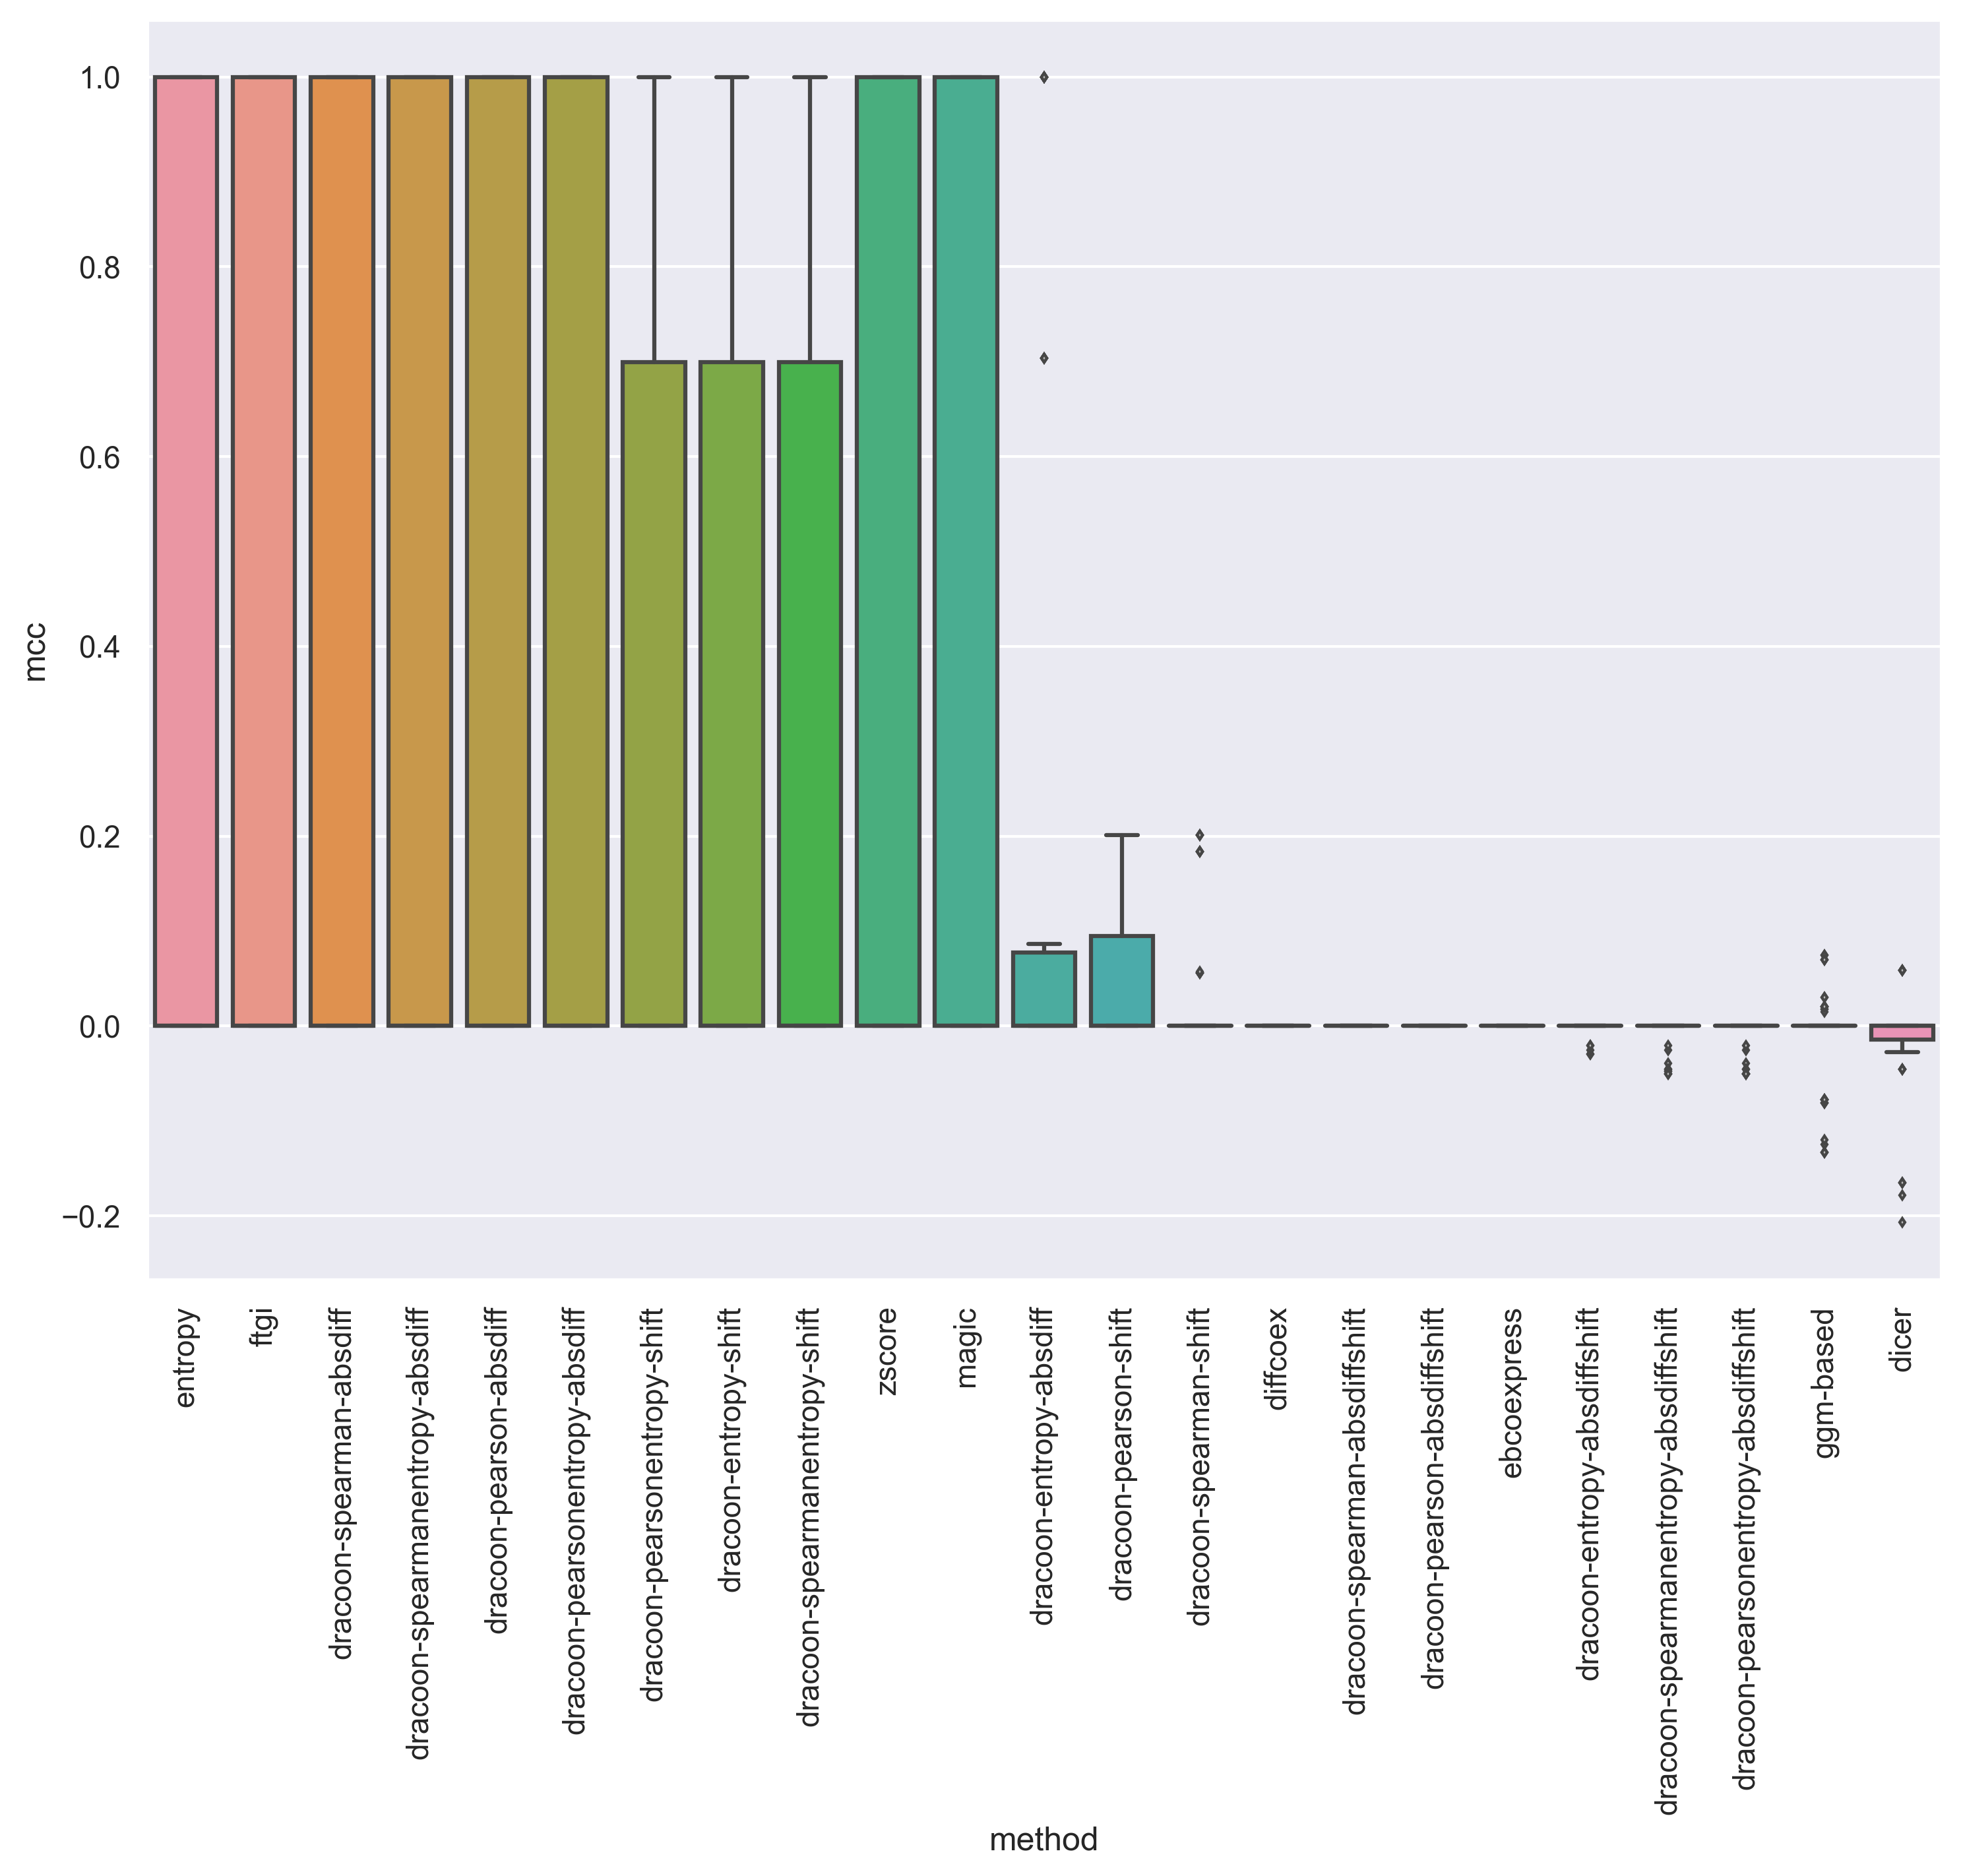

In [7]:
benchmark = 'perturbnoise'
df = final_results[final_results['benchmark'] == benchmark]


sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['ratio'], y = df['mcc'],
            hue = df['method'], flierprops=flierprops)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, -.3),
    ncol=3,
    title=None, frameon=False,
)
plt.xticks(rotation=70)
plt.show()



result2 = df.groupby(['method', 'ratio'], as_index=False)['mcc'].agg(['mean','std'])
result2.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
result2['CV'] = result2['std']/abs(result2['mean'])
result2.reset_index()

result = result2.pivot_table(index='method', columns='ratio', values='mean')
result.index = pd.CategoricalIndex(result.index)
result.sort_index(level=0, inplace=True)


sumres = df.groupby('method', as_index=False)['mcc'].agg(['mean','std'])
sumres.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
sumres['CV'] = sumres['std']/abs(sumres['mean'])
sumres = sumres.sort_values('mean', ascending=False).reset_index()
print(sumres)

#result = result.set_index('method')
result = result.reindex(sumres['method'])
result = result.reset_index()

# plot the heatmap
sns.heatmap(result.set_index('method'), annot=True, cmap='Blues', fmt=".3g", linewidths=2, linecolor='white')
plt.show()

sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['method'], y = df['mcc'], flierprops=flierprops, order=sumres['method'])
plt.xticks(rotation=90)
plt.show()

# 4. Comparing signal noises

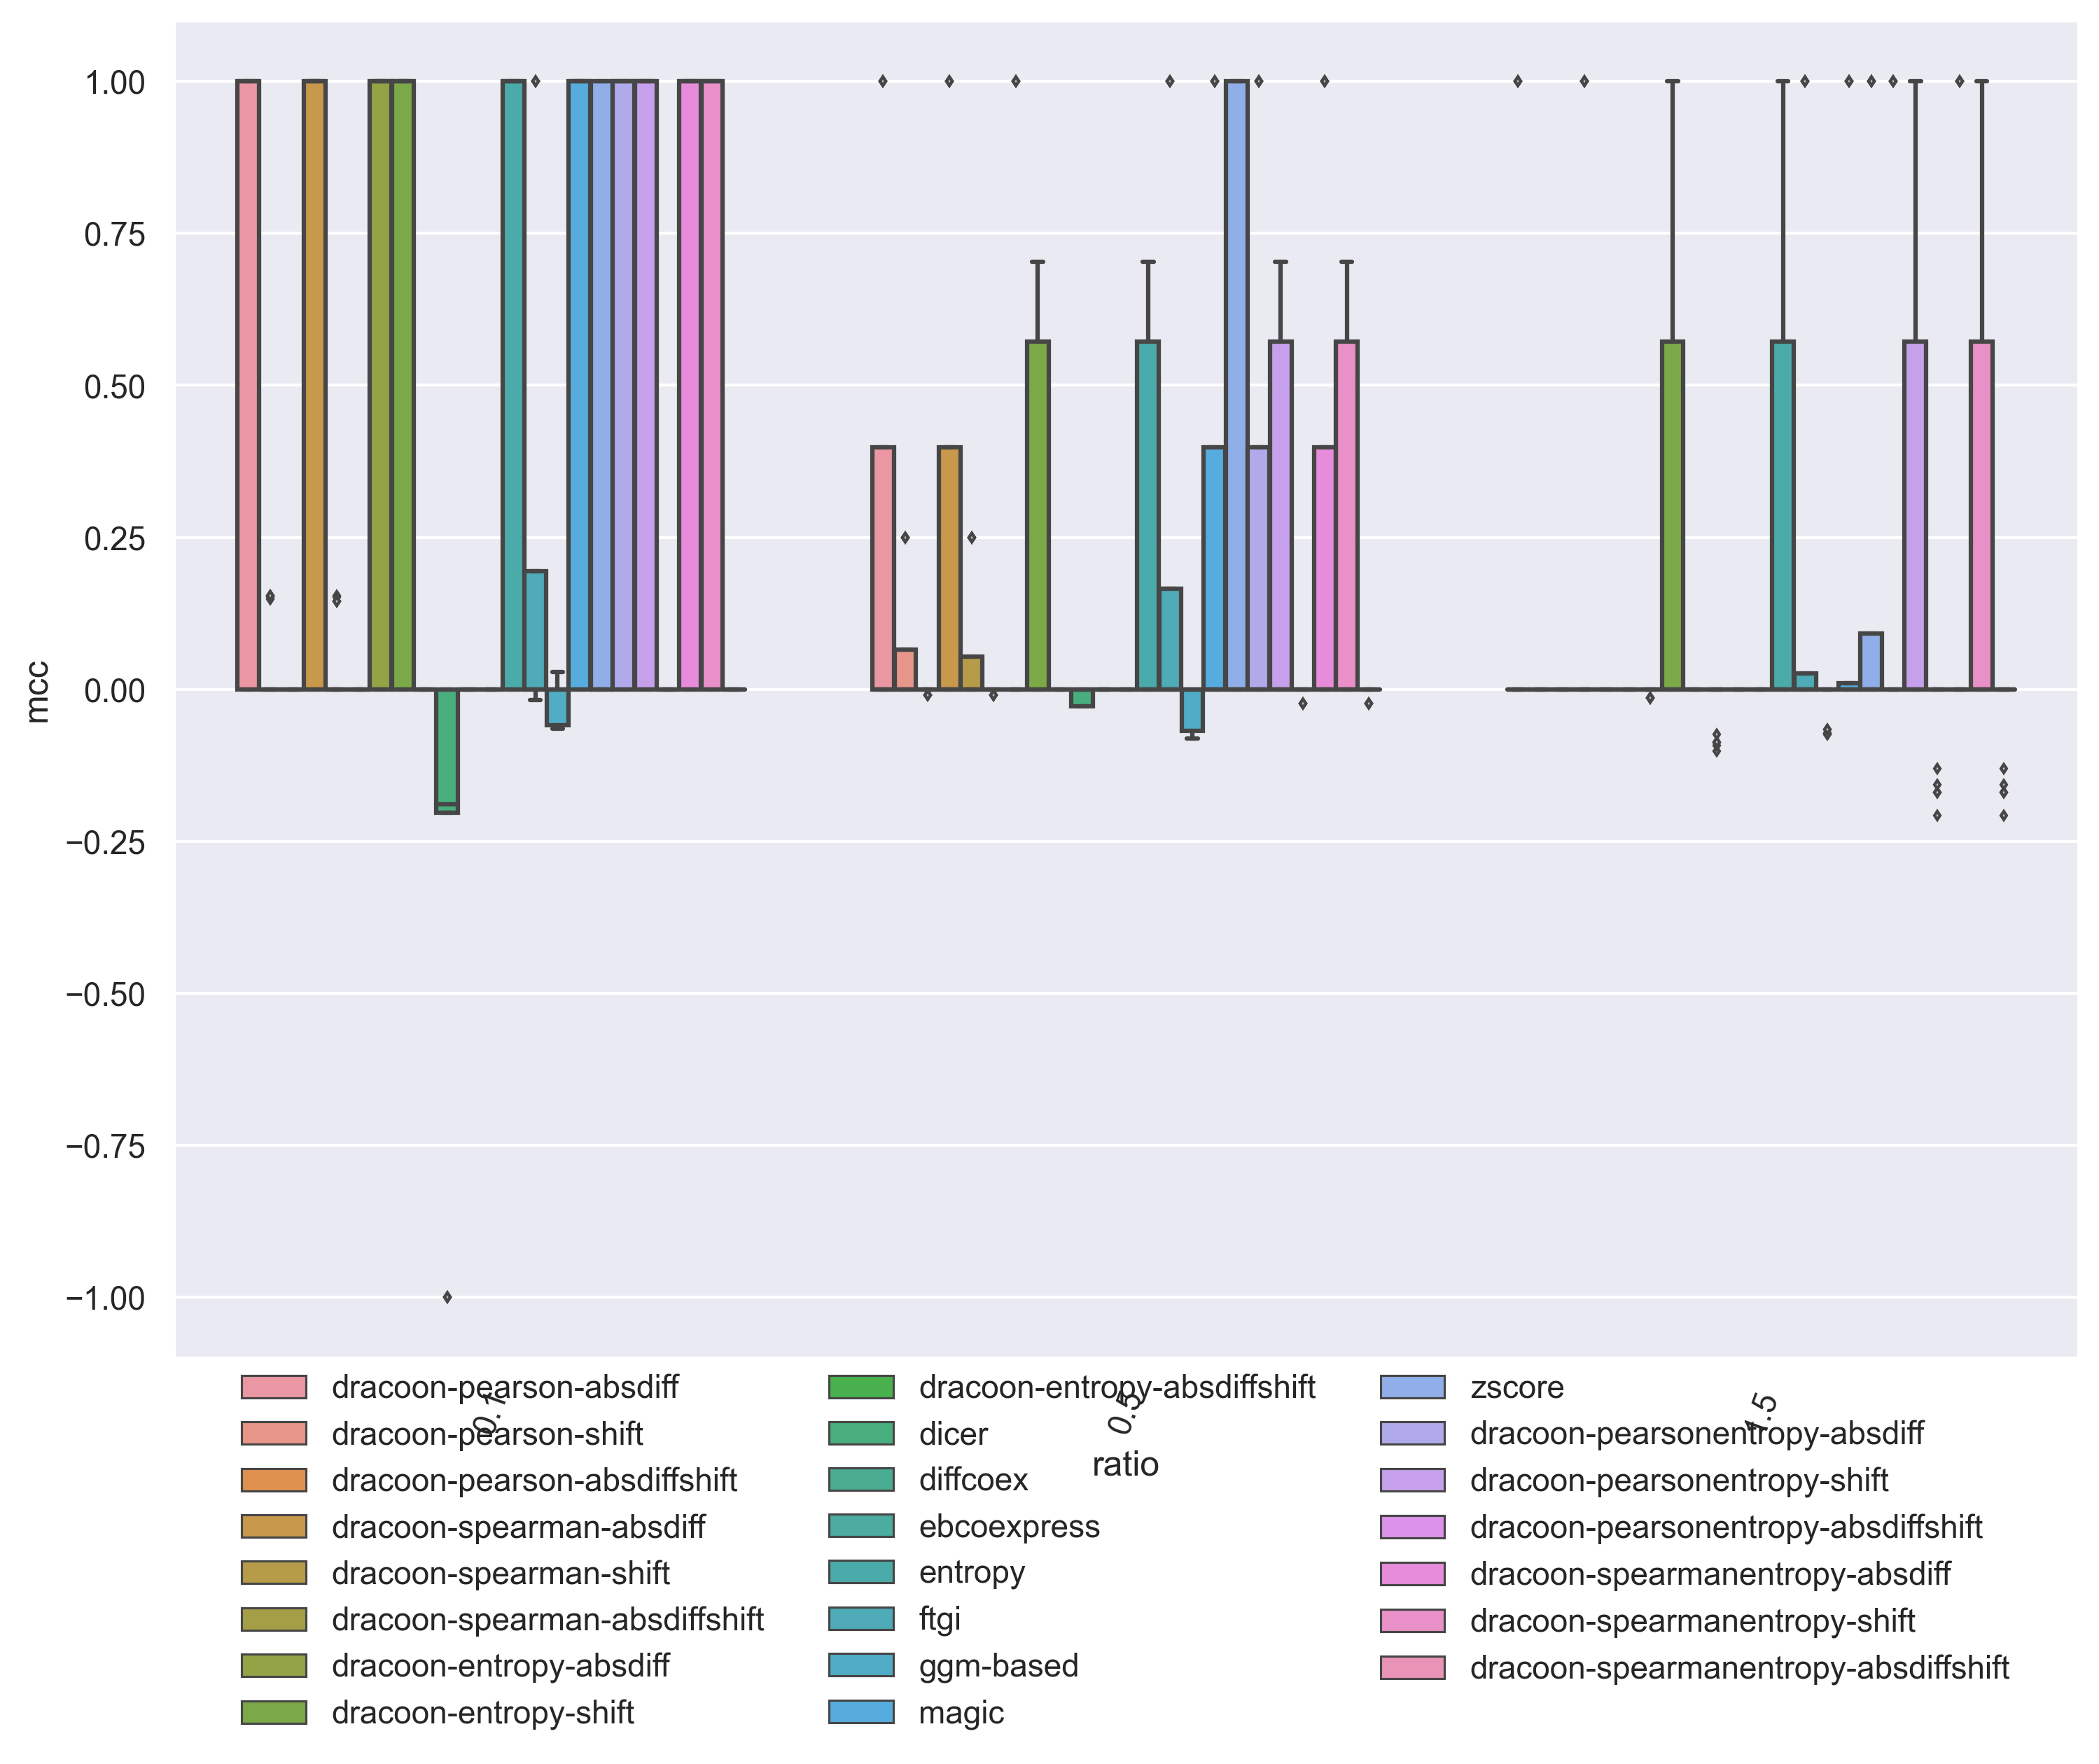

                                  method      mean       std        CV
0                                entropy  0.391517  0.441308  1.127175
1           dracoon-pearsonentropy-shift  0.389756  0.440309  1.129703
2                  dracoon-entropy-shift  0.389756  0.440309  1.129703
3          dracoon-spearmanentropy-shift  0.389756  0.440309  1.129703
4                                  magic  0.360119  0.465929  1.293820
5               dracoon-spearman-absdiff  0.359846  0.466139  1.295382
6                dracoon-pearson-absdiff  0.359846  0.466139  1.295382
7        dracoon-spearmanentropy-absdiff  0.359846  0.466139  1.295382
8         dracoon-pearsonentropy-absdiff  0.359846  0.466139  1.295382
9                                 zscore  0.339481  0.470752  1.386683
10               dracoon-entropy-absdiff  0.265700  0.445796  1.677820
11                                  ftgi  0.224462  0.395083  1.760134
12                 dracoon-pearson-shift  0.031081  0.071134  2.288679
13    

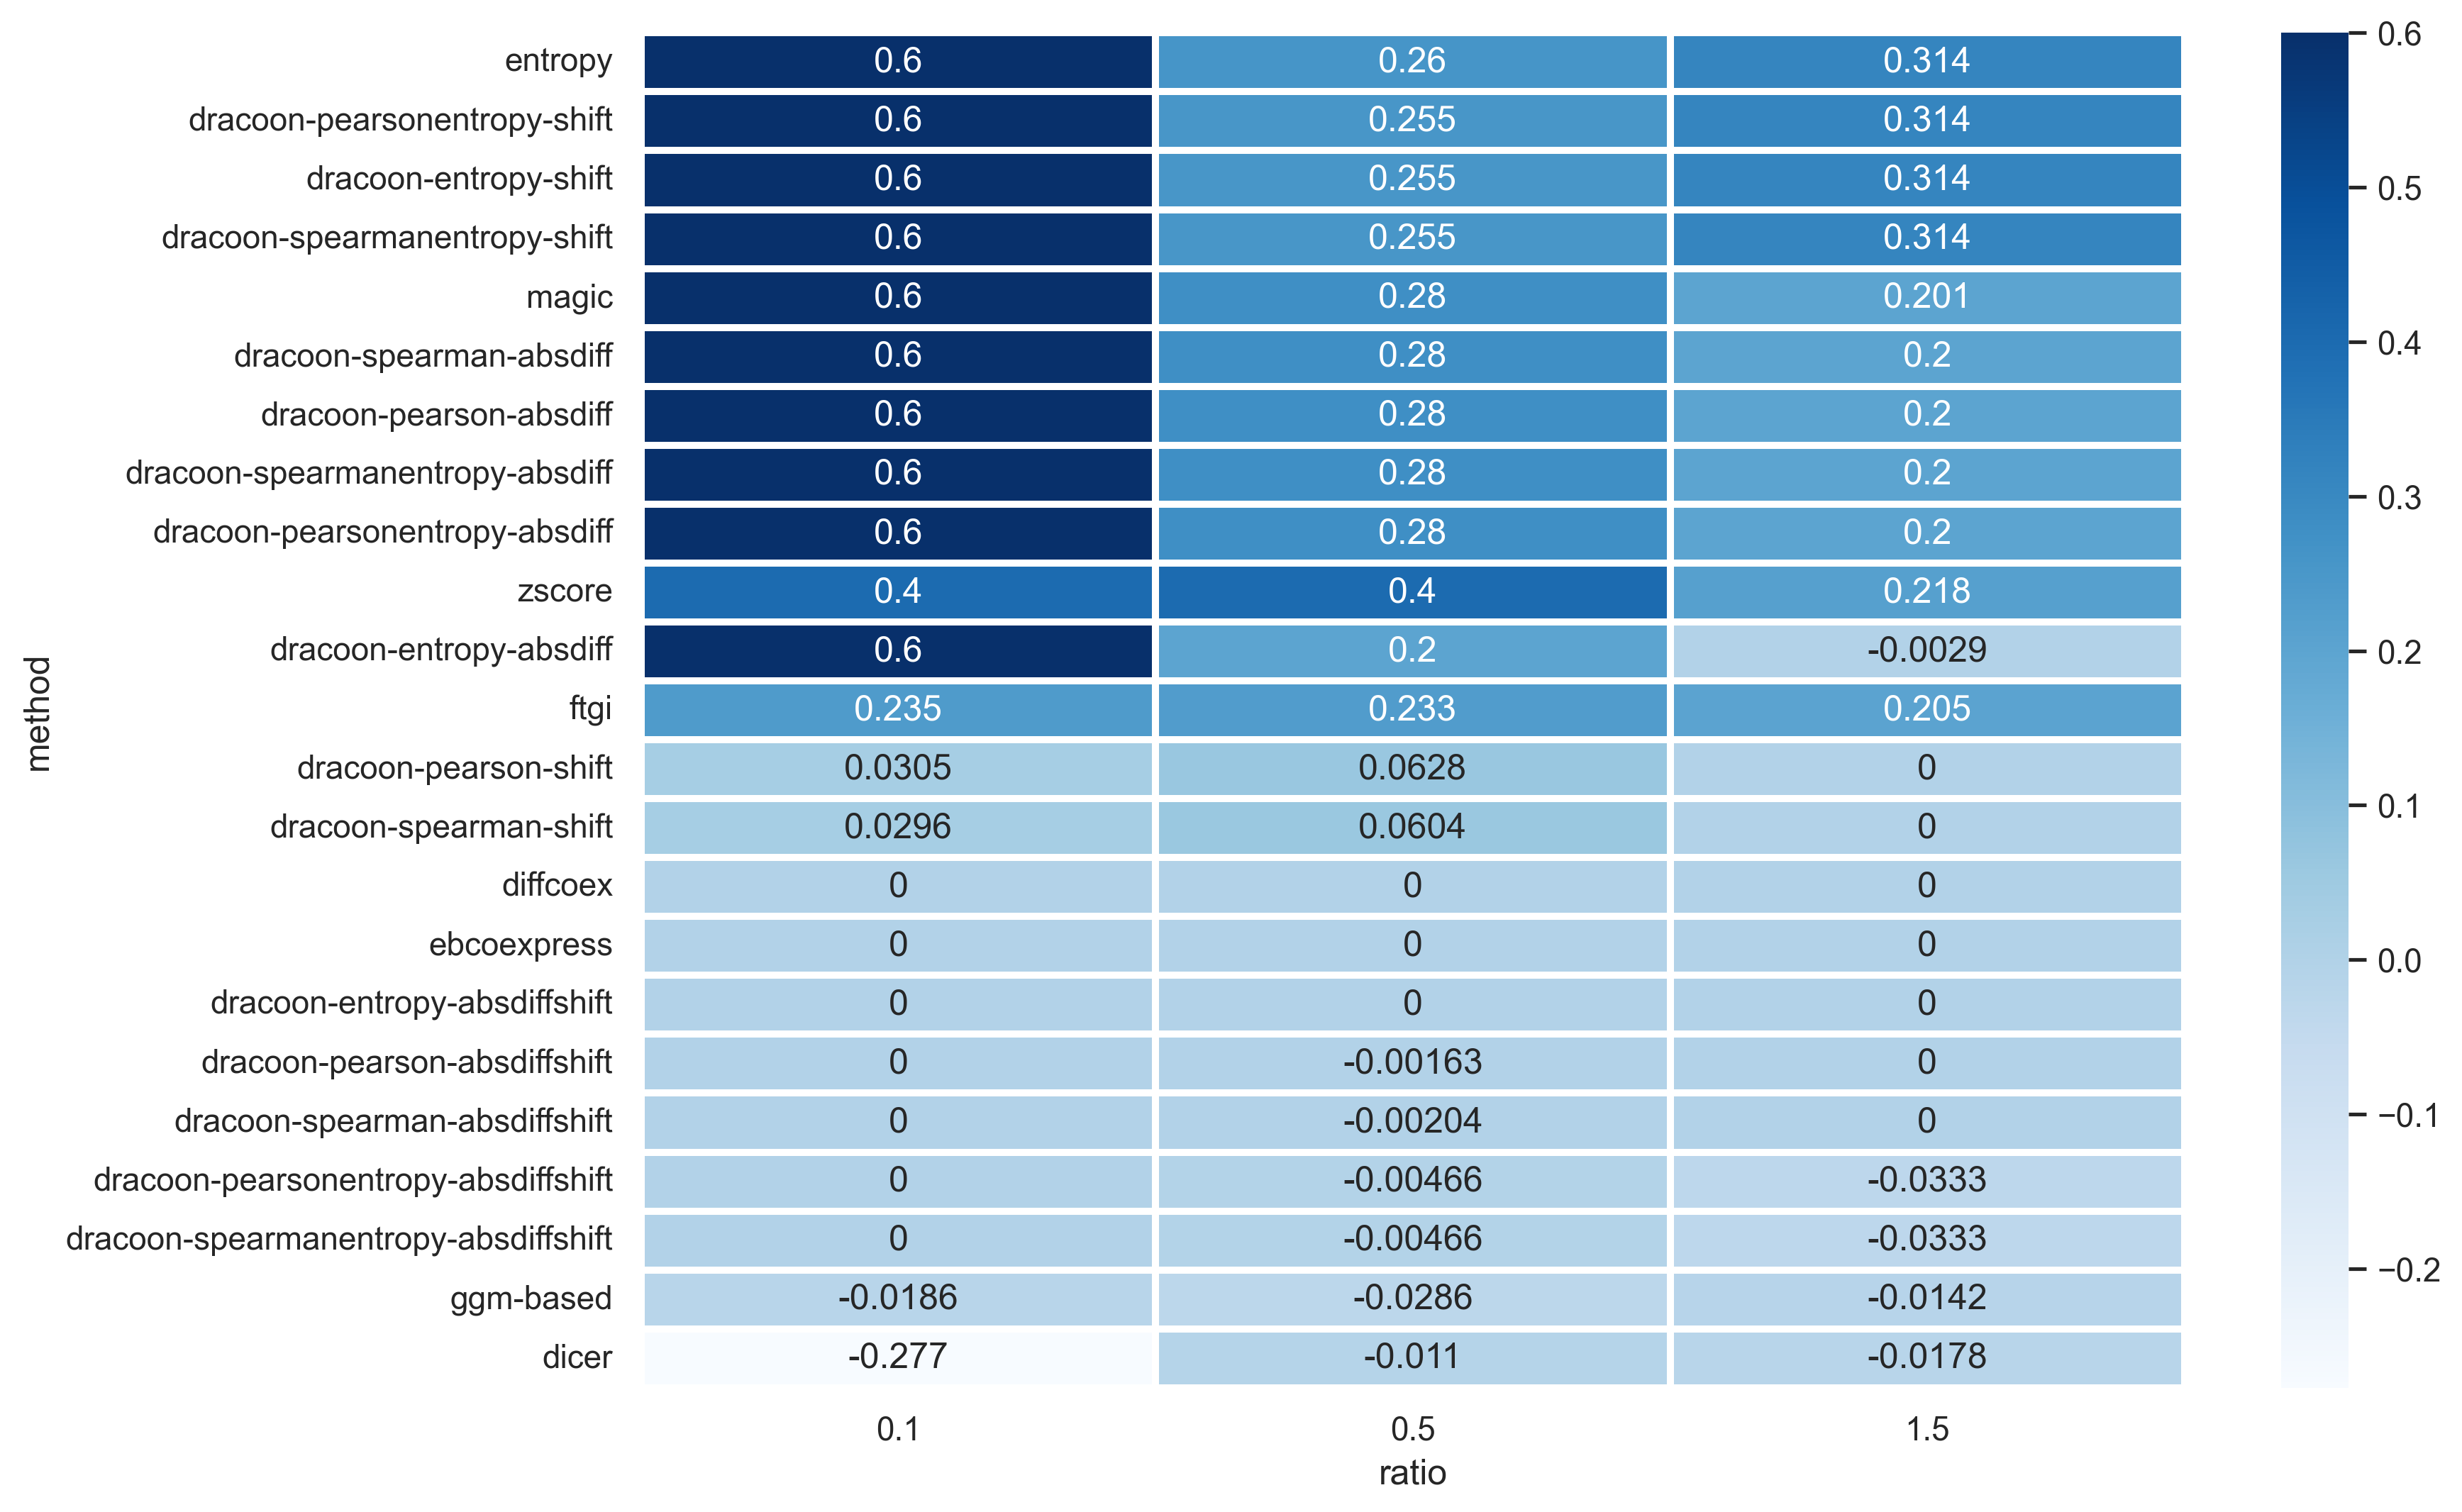

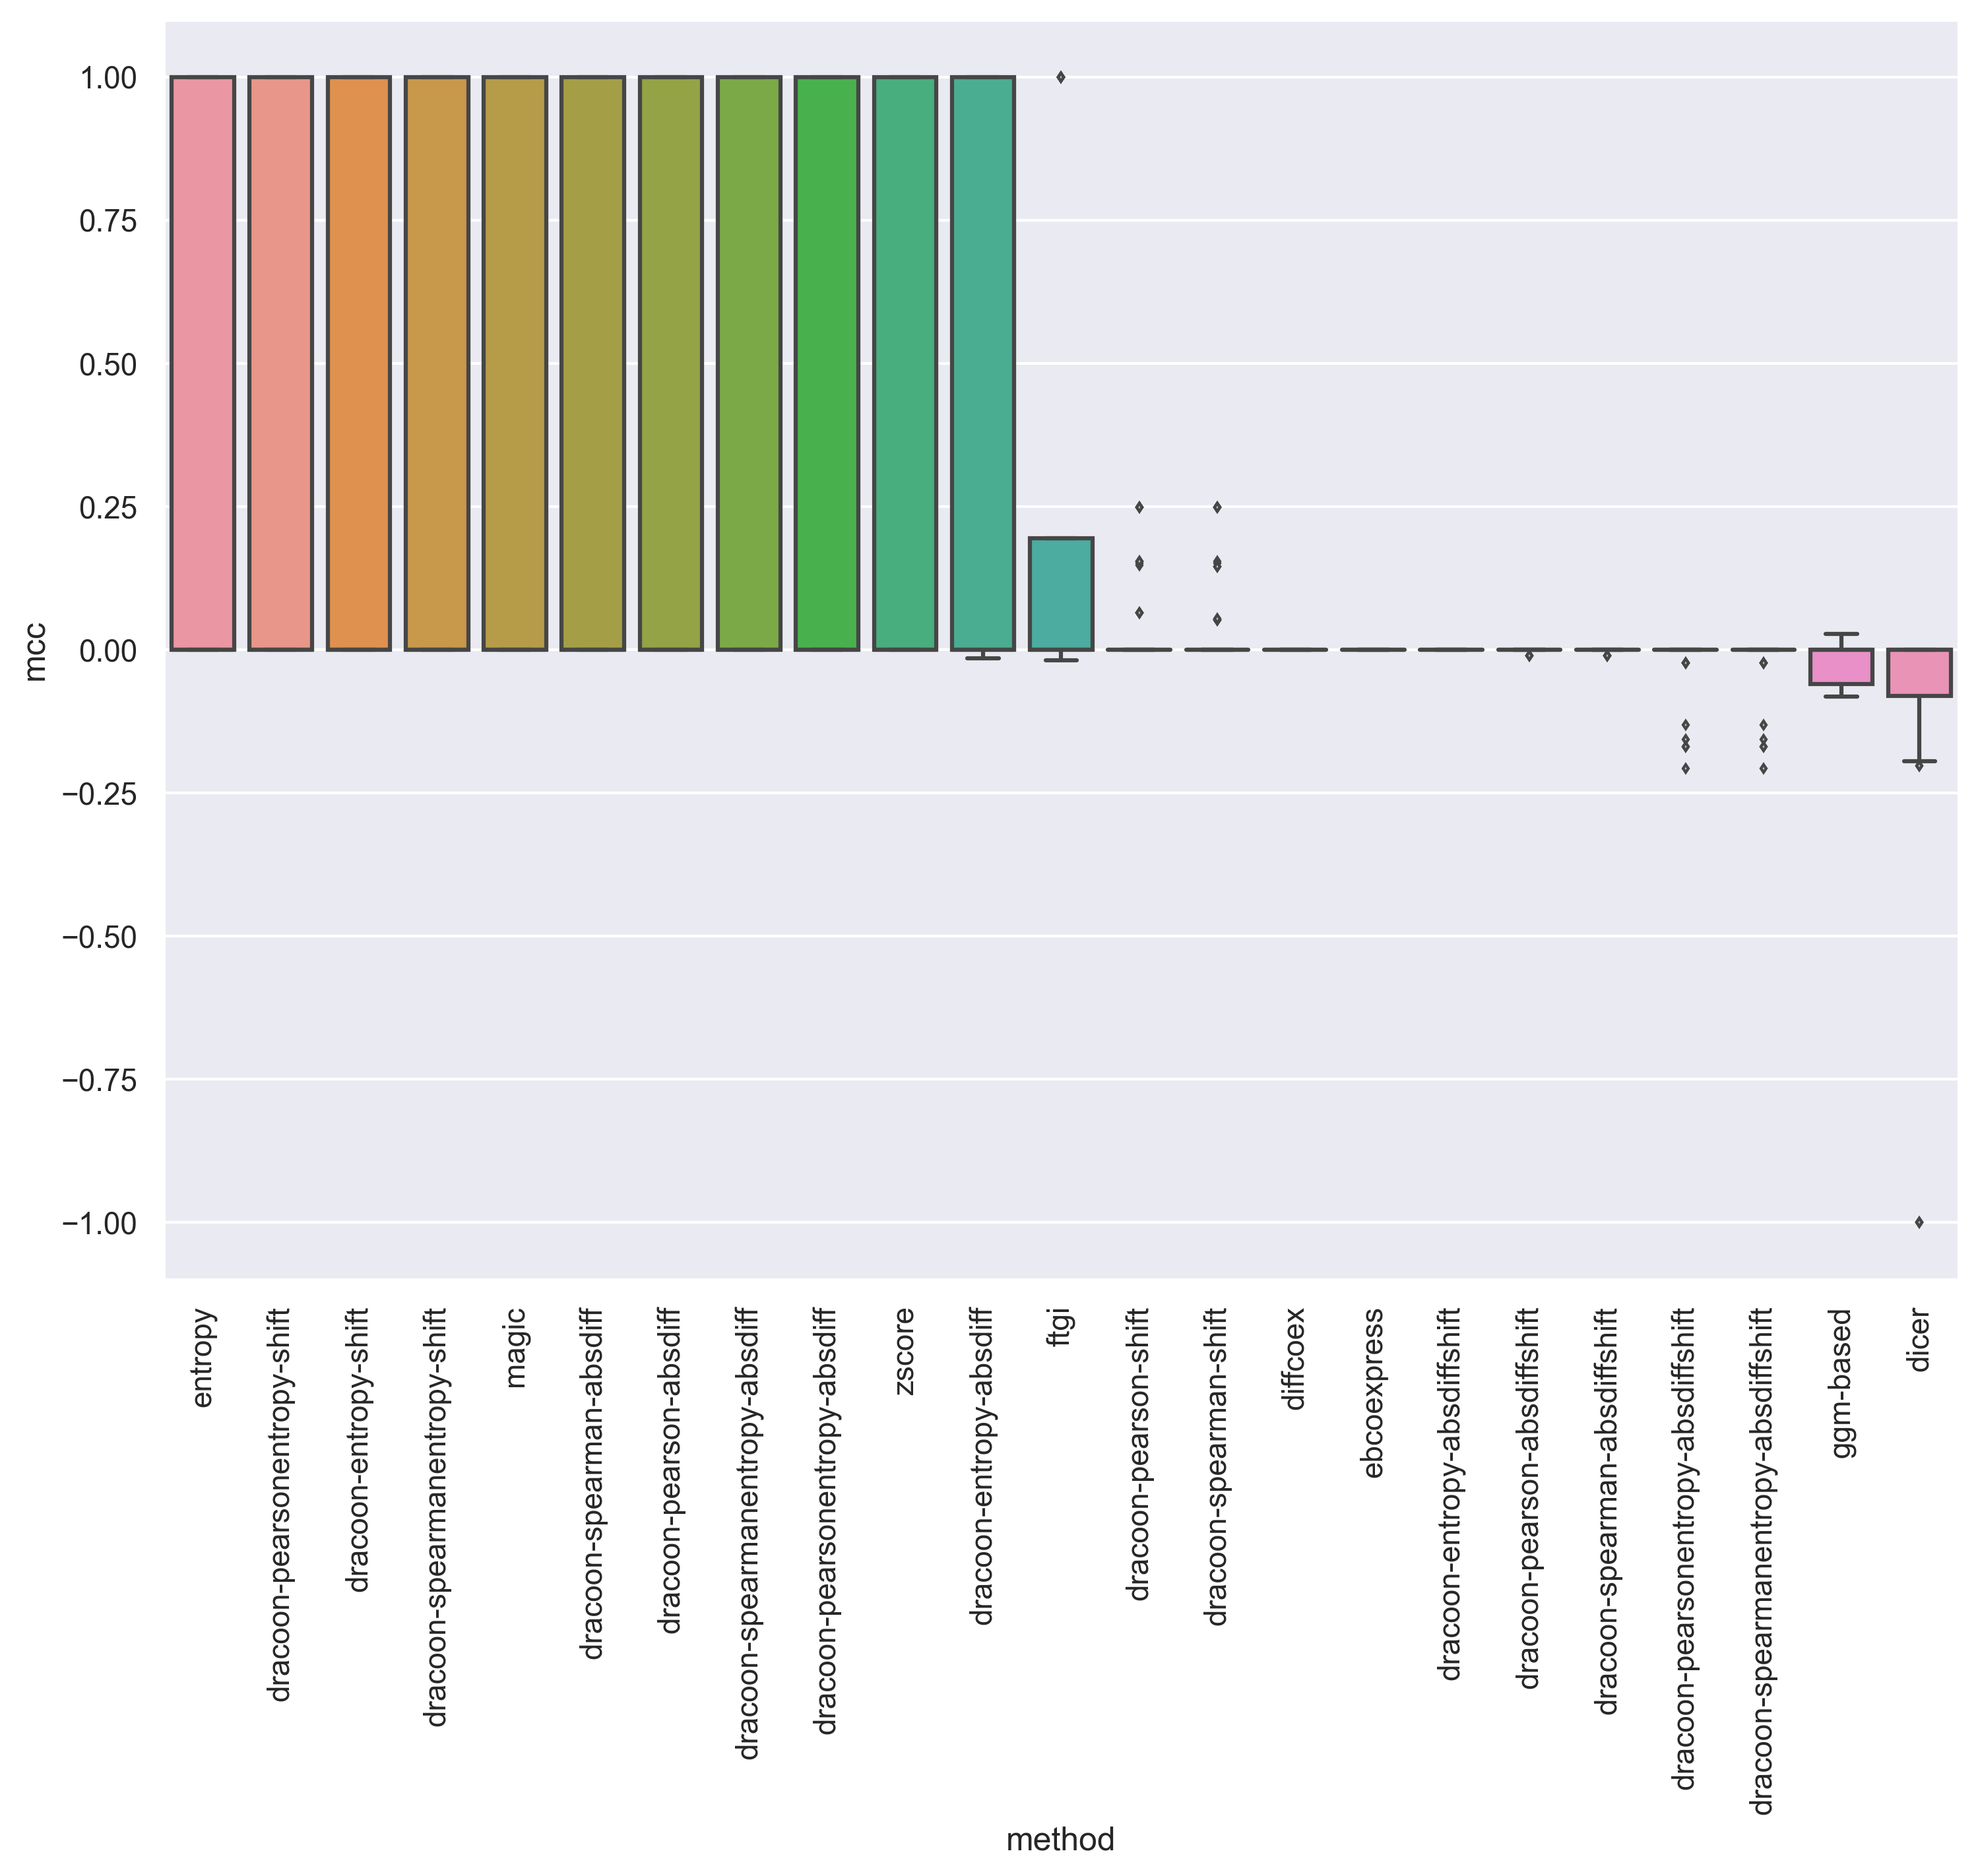

In [9]:
benchmark = 'signalnoise'
df = final_results[final_results['benchmark'] == benchmark]


sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['ratio'], y = df['mcc'],
            hue = df['method'], flierprops=flierprops)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, -.3),
    ncol=3,
    title=None, frameon=False,
)
plt.xticks(rotation=70)
plt.show()



result2 = df.groupby(['method', 'ratio'], as_index=False)['mcc'].agg(['mean','std'])
result2.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
result2['CV'] = result2['std']/abs(result2['mean'])
result2.reset_index()

result = result2.pivot_table(index='method', columns='ratio', values='mean')
result.index = pd.CategoricalIndex(result.index)
result.sort_index(level=0, inplace=True)


sumres = df.groupby('method', as_index=False)['mcc'].agg(['mean','std'])
sumres.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
sumres['CV'] = sumres['std']/abs(sumres['mean'])
sumres = sumres.sort_values('mean', ascending=False).reset_index()
print(sumres)

#result = result.set_index('method')
result = result.reindex(sumres['method'])
result = result.reset_index()

# plot the heatmap
sns.heatmap(result.set_index('method'), annot=True, cmap='Blues', fmt=".3g", linewidths=2, linecolor='white')
plt.show()

sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['method'], y = df['mcc'], flierprops=flierprops, order=sumres['method'])
plt.xticks(rotation=90)
plt.show()

# 5. Comparing gene numbers

# 6. Comparing in-group heterogeneity

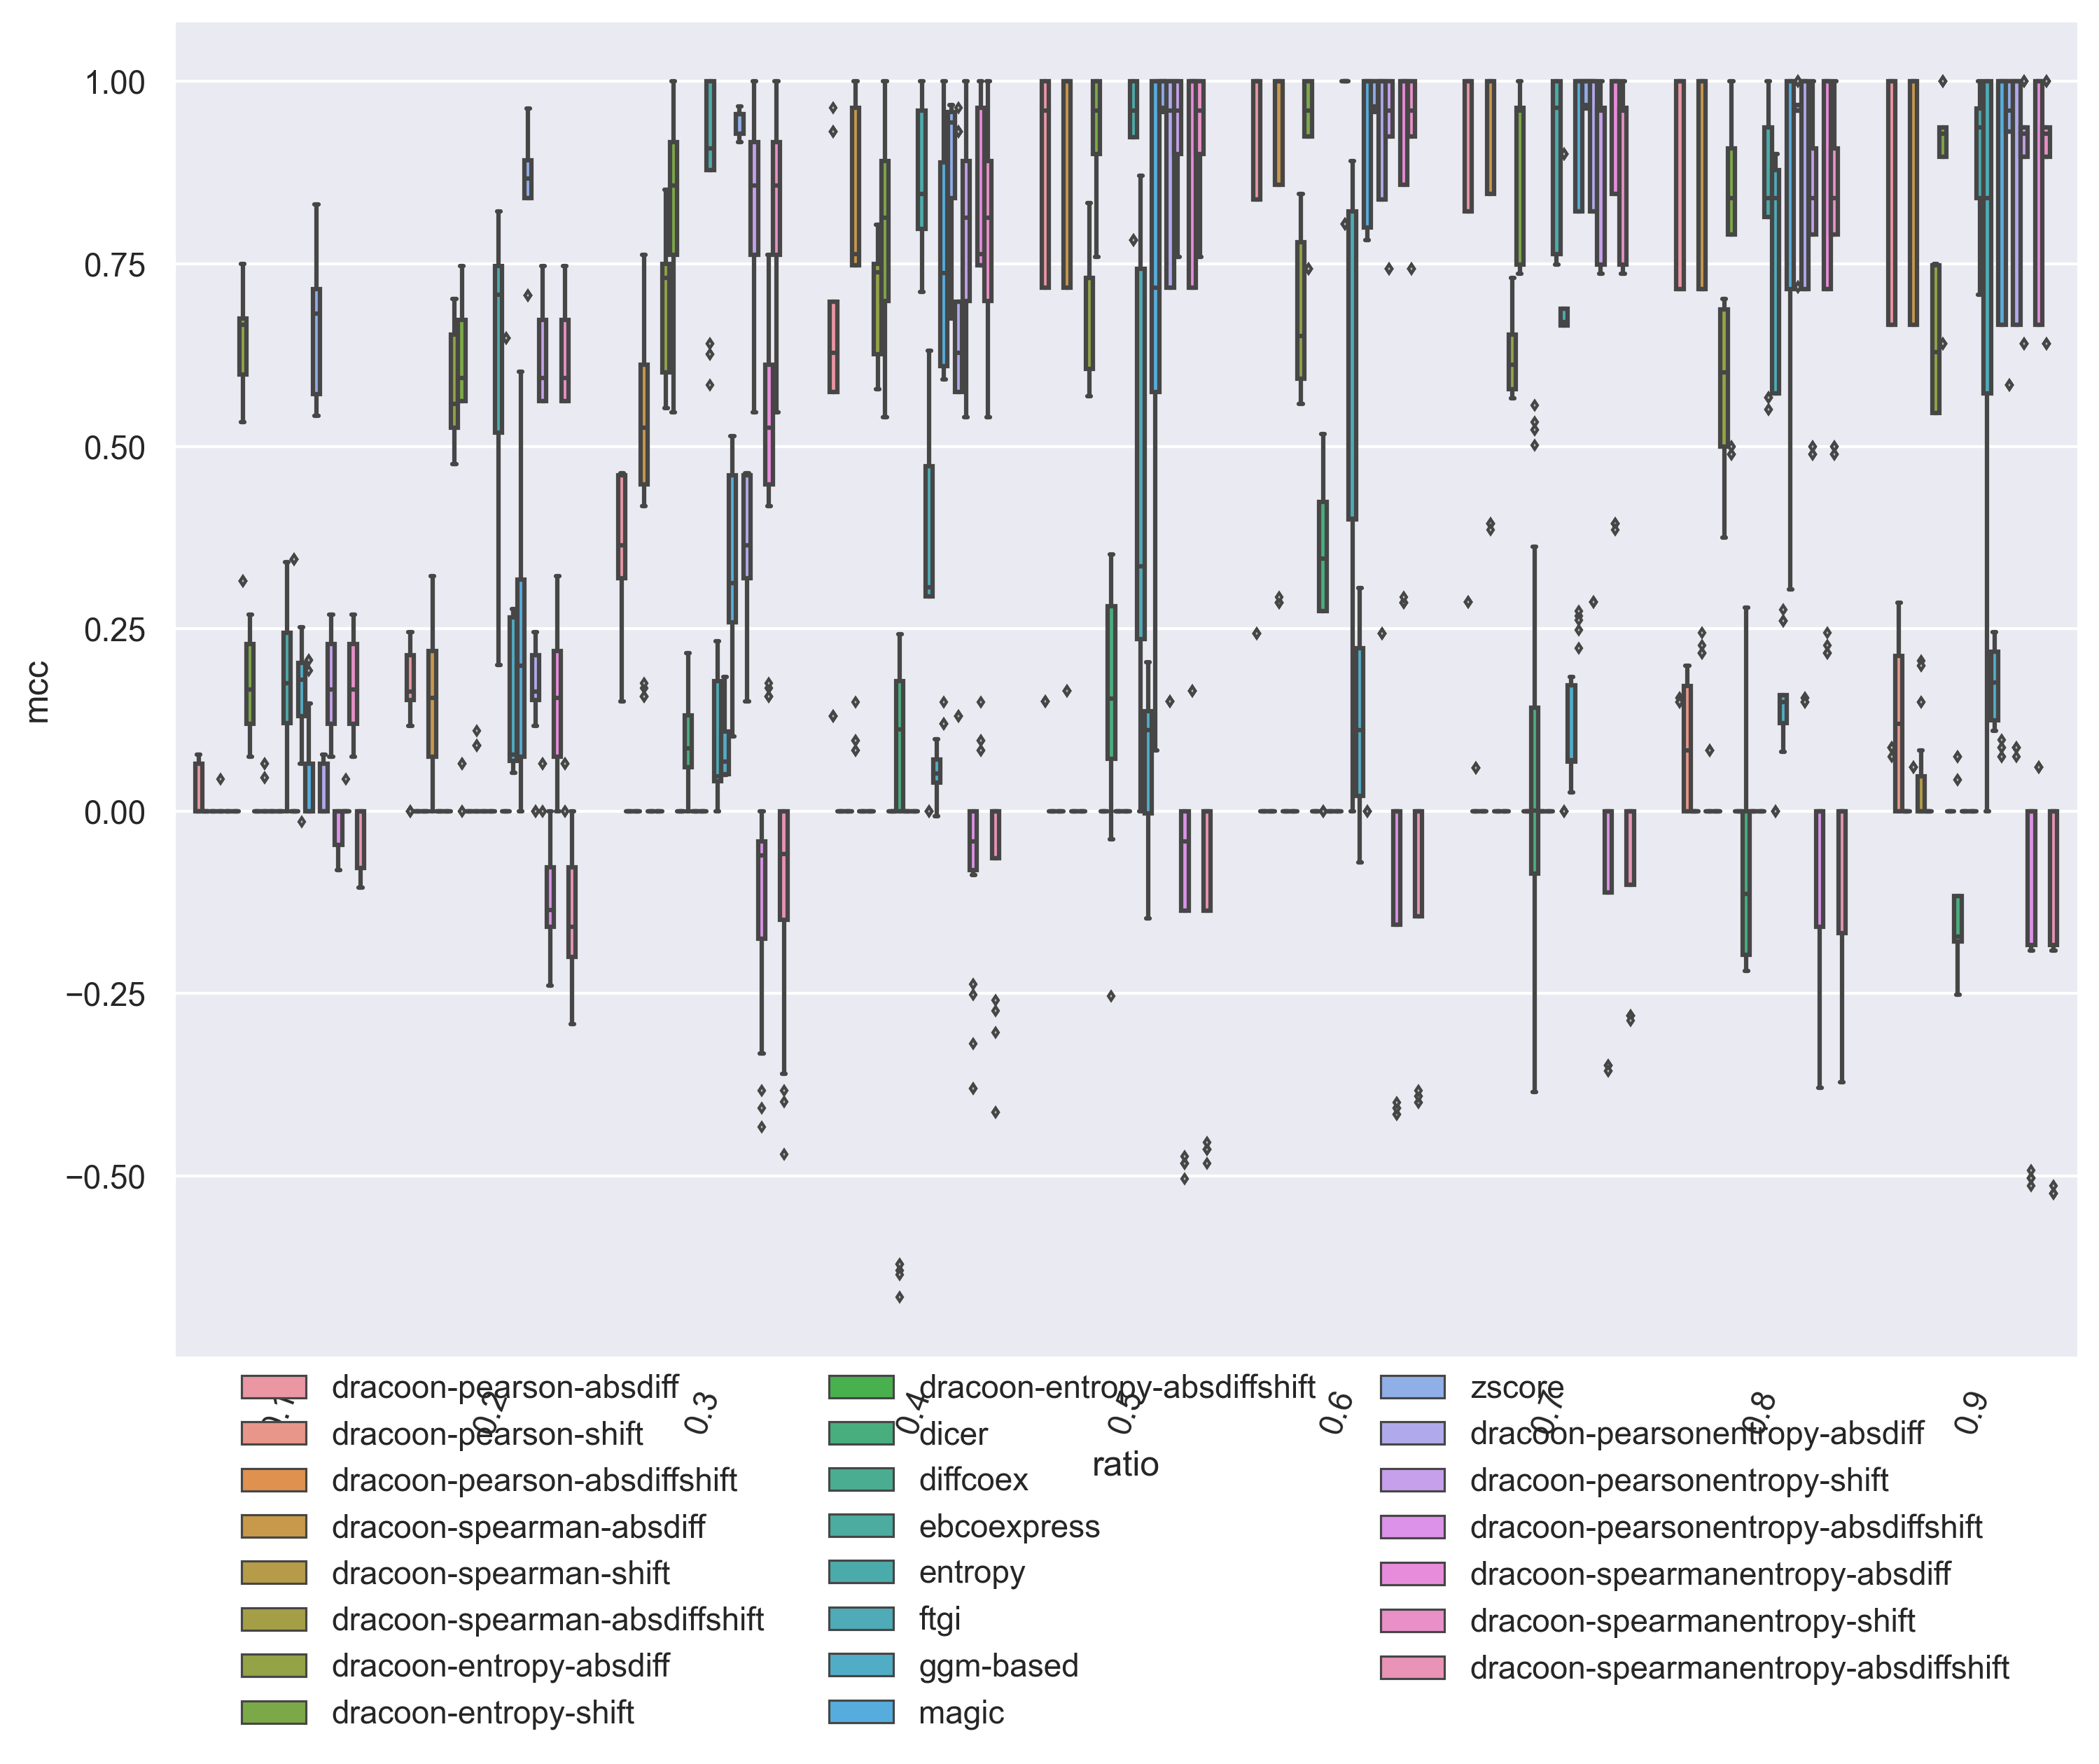

                                  method      mean       std        CV
0                                 zscore  0.900827  0.127739  0.141802
1                                entropy  0.783005  0.263851  0.336972
2           dracoon-pearsonentropy-shift  0.747502  0.274490  0.367210
3                  dracoon-entropy-shift  0.747502  0.274490  0.367210
4          dracoon-spearmanentropy-shift  0.747502  0.274490  0.367210
5                dracoon-entropy-absdiff  0.642136  0.112309  0.174899
6        dracoon-spearmanentropy-absdiff  0.595070  0.395006  0.663797
7               dracoon-spearman-absdiff  0.595070  0.395006  0.663797
8                                  magic  0.566799  0.386882  0.682574
9         dracoon-pearsonentropy-absdiff  0.562581  0.386851  0.687635
10               dracoon-pearson-absdiff  0.562581  0.386851  0.687635
11                                  ftgi  0.387238  0.359176  0.927533
12                             ggm-based  0.119505  0.087994  0.736325
13    

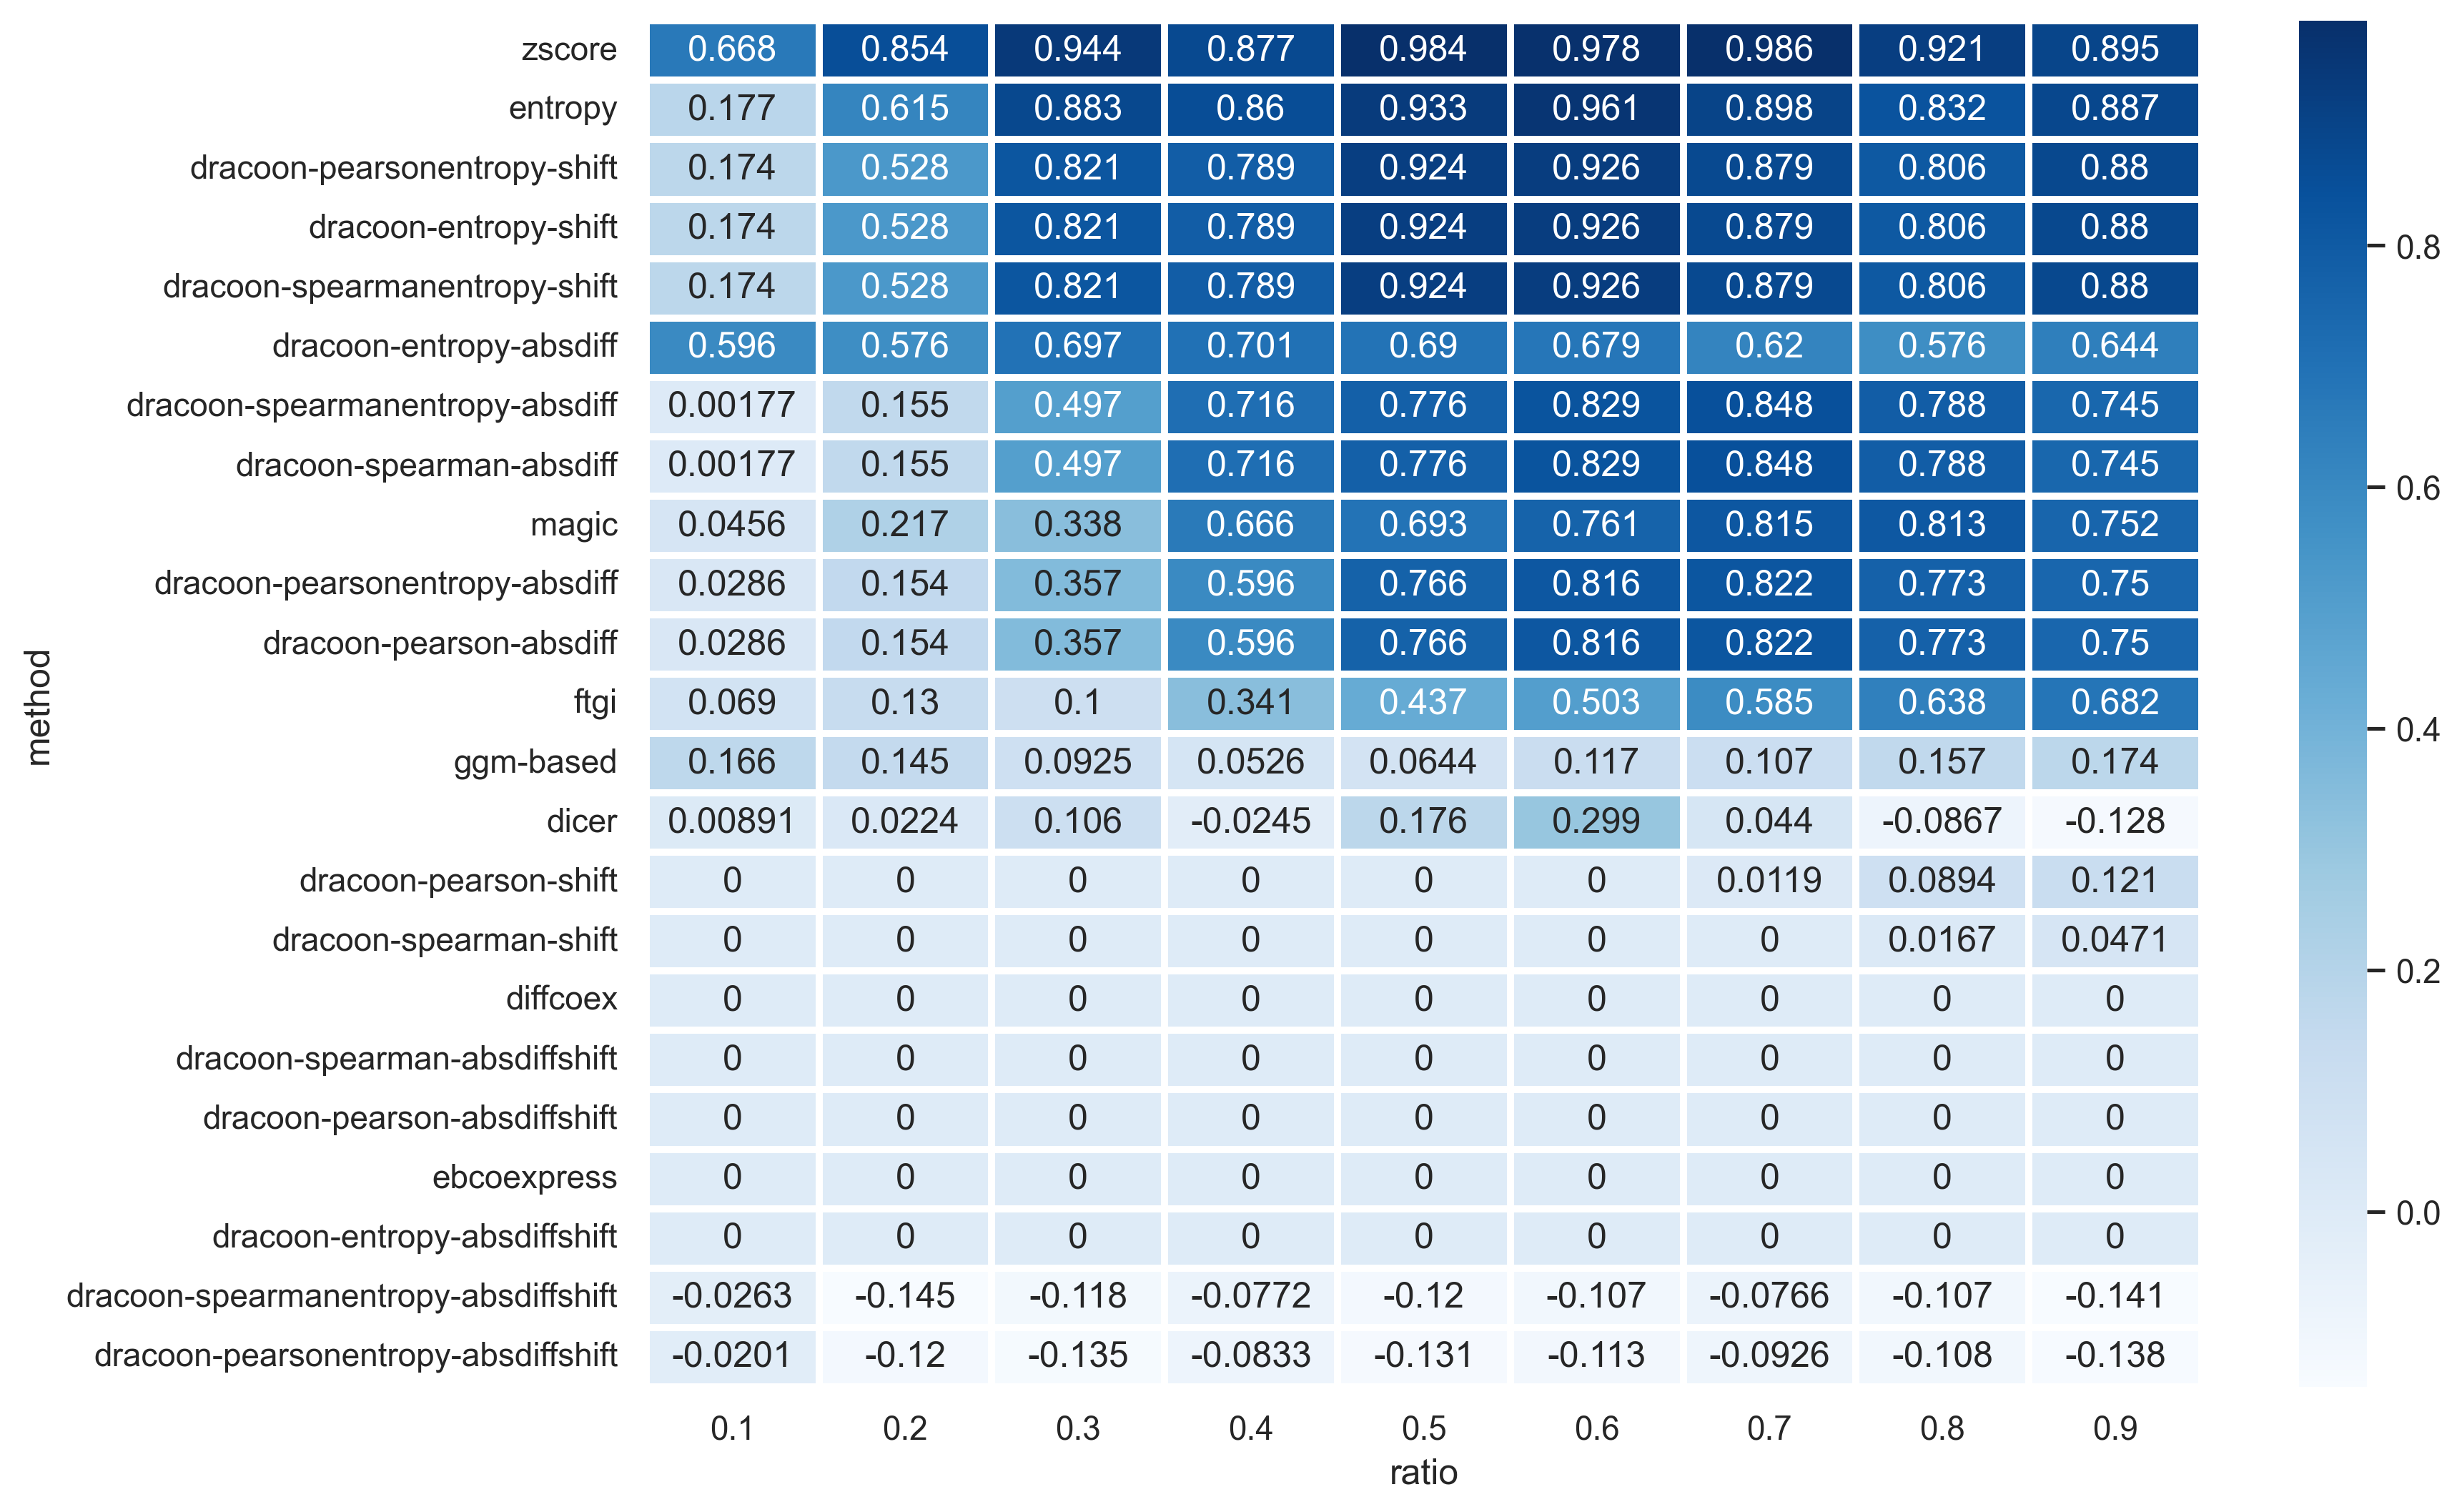

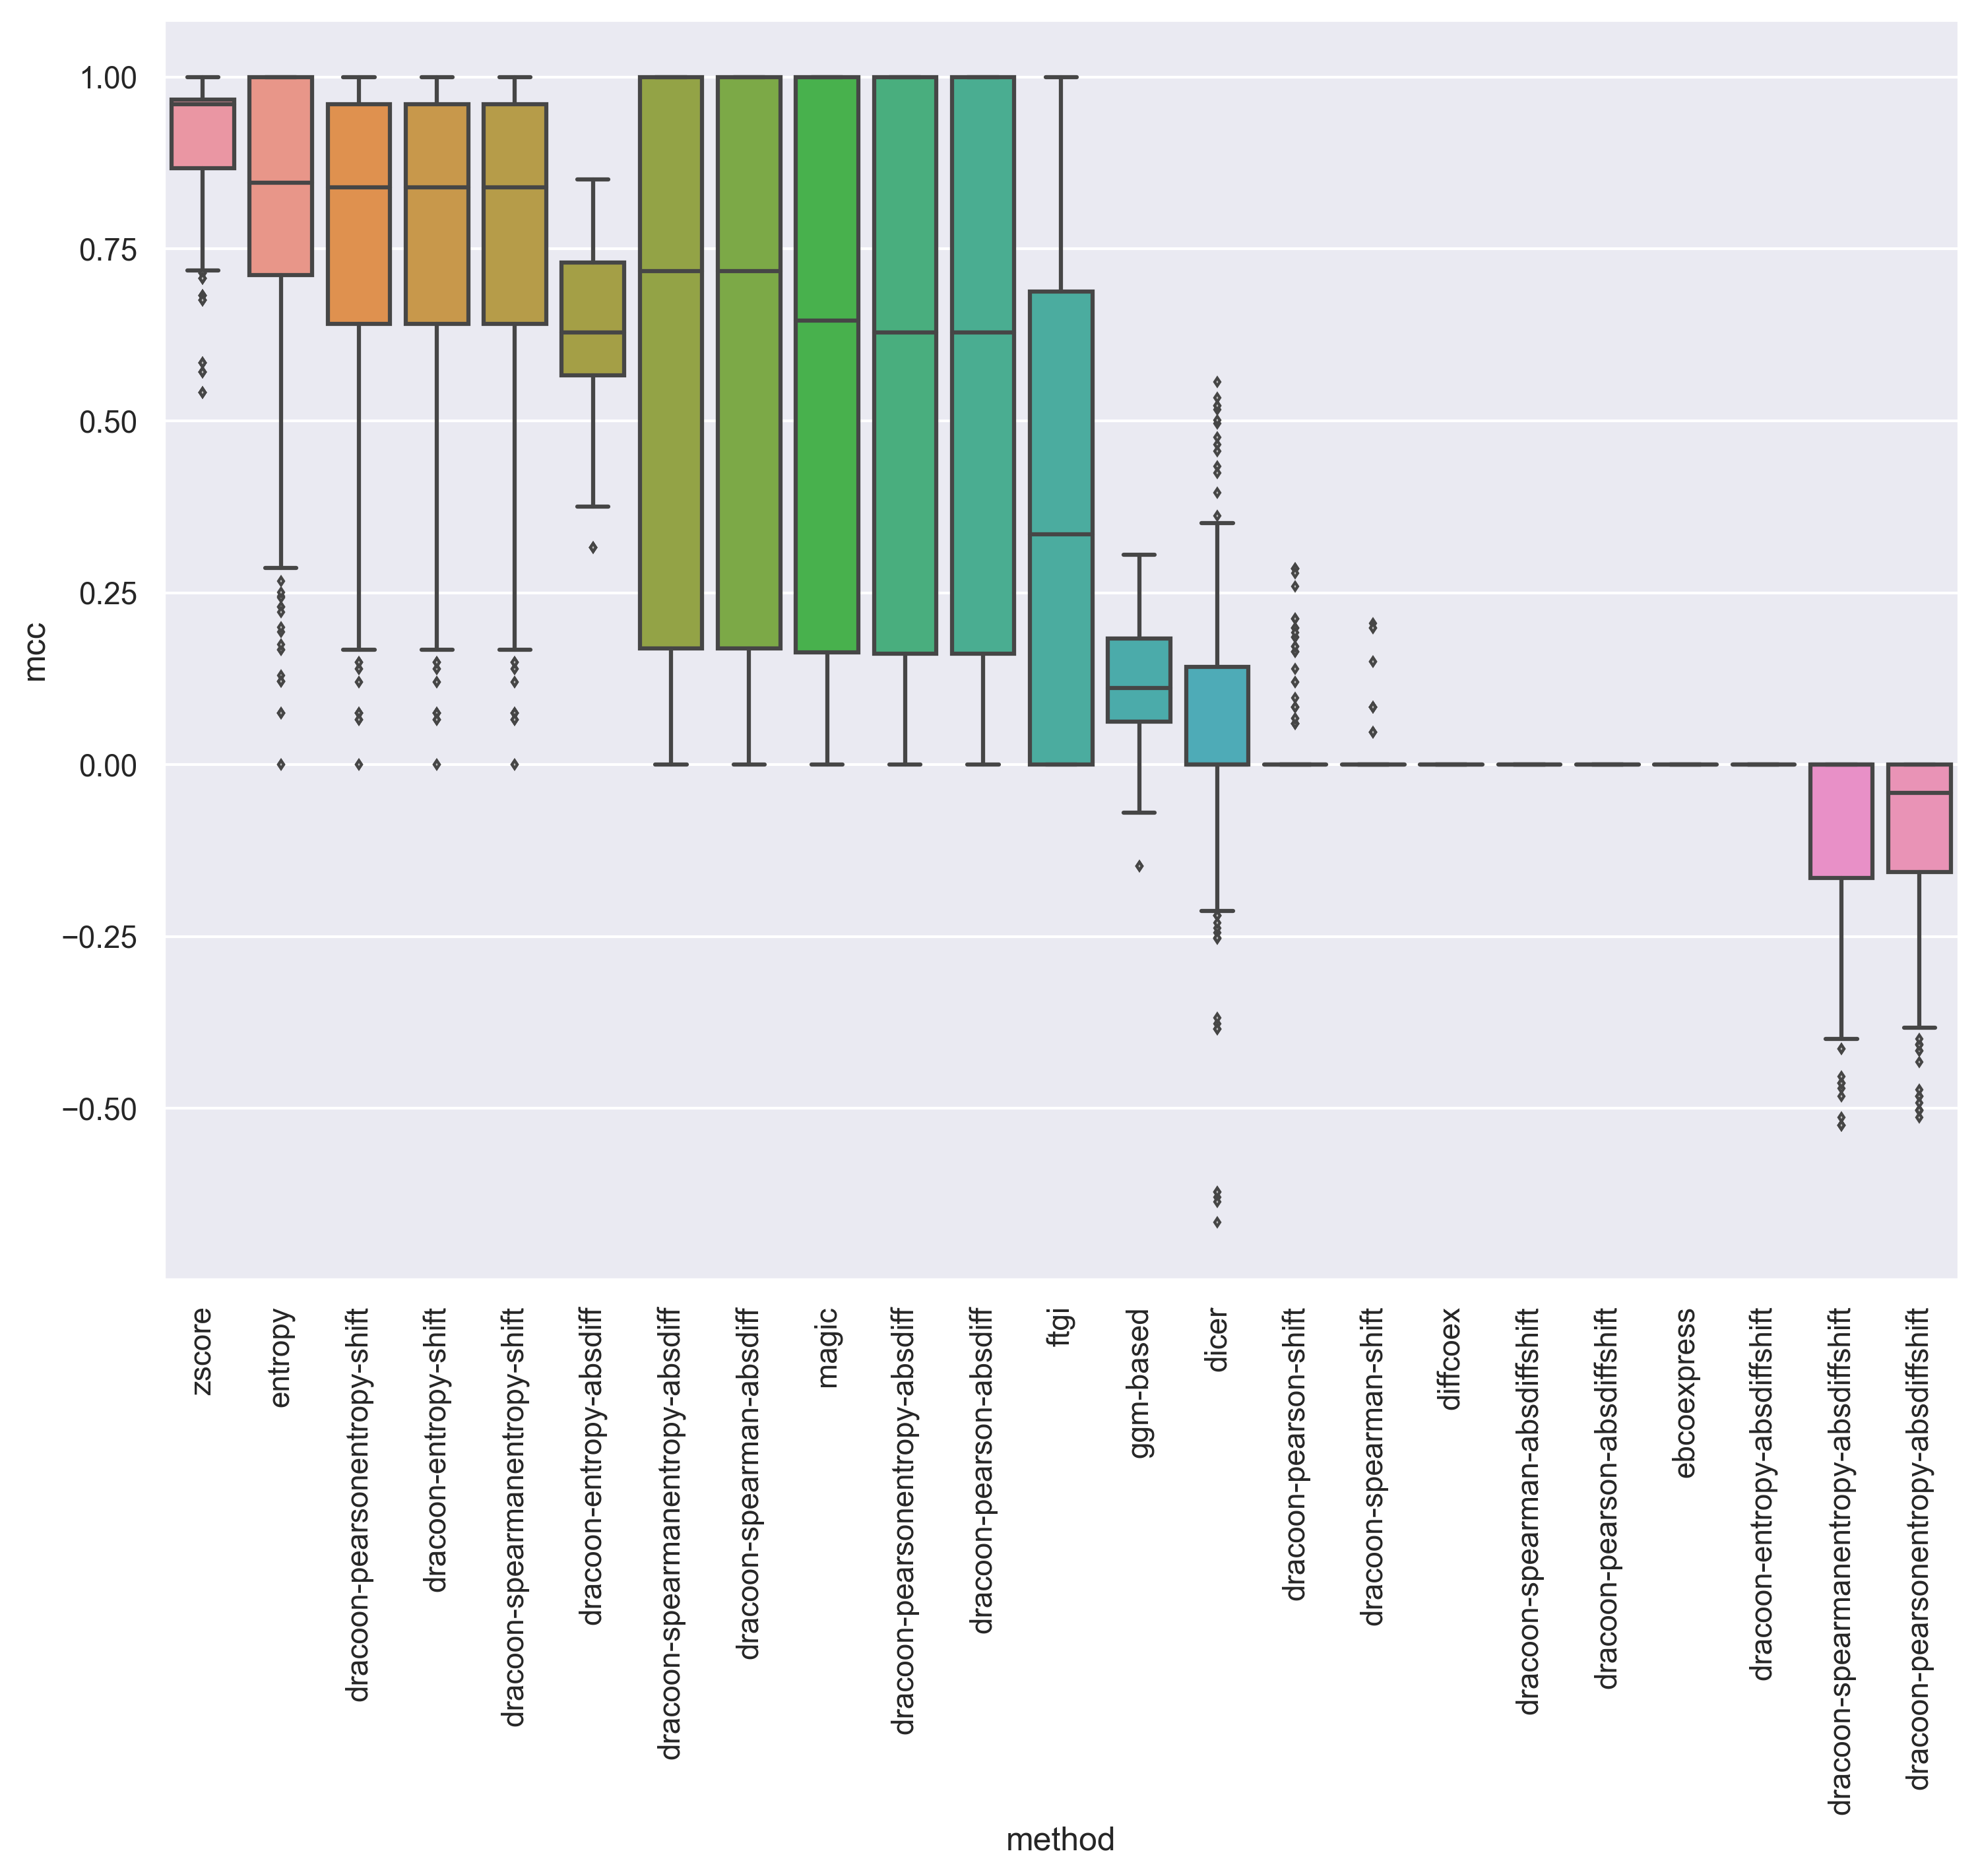

In [10]:
benchmark = 'propingroup'
df = final_results[final_results['benchmark'] == benchmark]


sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['ratio'], y = df['mcc'],
            hue = df['method'], flierprops=flierprops)
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(0.5, -.3),
    ncol=3,
    title=None, frameon=False,
)
plt.xticks(rotation=70)
plt.show()



result2 = df.groupby(['method', 'ratio'], as_index=False)['mcc'].agg(['mean','std'])
result2.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
result2['CV'] = result2['std']/abs(result2['mean'])
result2.reset_index()

result = result2.pivot_table(index='method', columns='ratio', values='mean')
result.index = pd.CategoricalIndex(result.index)
result.sort_index(level=0, inplace=True)


sumres = df.groupby('method', as_index=False)['mcc'].agg(['mean','std'])
sumres.reindex(['method', 'ratio', 'mean', 'std'], axis="columns")
sumres['CV'] = sumres['std']/abs(sumres['mean'])
sumres = sumres.sort_values('mean', ascending=False).reset_index()
print(sumres)

#result = result.set_index('method')
result = result.reindex(sumres['method'])
result = result.reset_index()

# plot the heatmap
sns.heatmap(result.set_index('method'), annot=True, cmap='Blues', fmt=".3g", linewidths=2, linecolor='white')
plt.show()

sns.set(rc={'figure.figsize':(11.7,8.27)})
flierprops = dict(markerfacecolor='0.75', markersize=2, linestyle='none')

ax = sns.boxplot(x = df['method'], y = df['mcc'], flierprops=flierprops, order=sumres['method'])
plt.xticks(rotation=90)
plt.show()